<a href="https://colab.research.google.com/github/dongwon0002/DataMininig_term/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 원본 데이터 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd

df_apt = pd.read_csv('/content/drive/MyDrive/DataMining/term project/data/OG/아파트(전월세)_실거래가_20250522185247.csv',encoding="cp949", header=15)
df_vil = pd.read_csv('/content/drive/MyDrive/DataMining/term project/data/OG/연립다세대(전월세)_실거래가_20250522185244.csv',encoding="cp949", header=15)

## 원본 데이터

| 시군구               | 번지   | 본번 | 부번 | 전월세구분 | 전용면적(㎡) | 계약년월 | 계약일 | 보증금(만원) | 월세금(만원) | 층  | 건축년도 | 도로명                          | 계약기간         | 계약구분 | 갱신요구권 사용 | 주택유형 | 건물명           |
|----------------------|--------|------|------|------------|--------------|----------|--------|---------------|---------------|------|----------|-----------------------------------|------------------|----------|------------------|----------|------------------|
| 서울특별시 광진구 광장동 | 554-7 | 554  | 7    | 전세       | 84.53        | 202412   | 31     | 74,000        | 0             | 7    | 1989     | 서울특별시 광진구 광장동554-7    | 202504~202704    | 신규     | -                | 아파트   | 현대5            |
| 서울특별시 광진구 광장동 | 218-1 | 218  | 1    | 전세       | 75.55        | 202412   | 31     | 54,000        | 0             | 8    | 1989     | 서울특별시 광진구 광장동218-1    | 202502~202702    | 신규     | -                | 아파트   | 극동2            |
| 서울특별시 성동구 금호동2가 | 1      | 1    | 0    | 월세       | 84.98        | 202412   | 31     | 75,000        | 80            | 12   | 2016     | 서울특별시 성동구 금호동2가1     | 202502~202702    | 신규     | -                | 아파트   | 신금호파크자이    |
| 서울특별시 성동구 행당동   | 375    | 375  | 0    | 전세       | 59.99        | 202412   | 31     | 70,000        | 0             | 6    | 2009     | 서울특별시 성동구 행당동375      | 202503~202703    | 신규     | -                | 아파트   | 행당두산위브      |
| 서울특별시 성동구 행당동   | 380    | 380  | 0    | 월세       | 84.90        | 202412   | 31     | 70,000        | 120           | 22   | 2018     | 서울특별시 성동구 행당동380      | 202502~202702    | 신규     | -                | 아파트   | 서울숲리버뷰자이  |


### - ```계약구분```,```갱신요구권 사용```삭제,
### - ```시군구``` -> ```시```,```군```,```구```로 나누기
### - ```보증금(만원)```,```월세금(만원)``` => 컴마 삭제하고 int type으로 변환
### - ```계약년월``` -> ```계약년```,```계약월```
### - ```계약기간``` -> 개월수로 교체 -> 120이상이면 공공임대 주택으로 예상하고 행 제거
### - ```계약기간``` 이 '-'로 채워진 경우 삭제
### - ```계약년```보다 ```계약시작연```이 큰 경우, 행 제거
### - ```전월세구분``` == '월세'가 아니면 삭제
### - 120개월 미만의 계약만 유지
### - ```월세/면적```컬럼 생성, ```보증금/월세```컬럼 생성

### 자기자본으로 보증금을 마련하는 경우 (기회비용)
$$[
\text{월 부담액} = \left( \frac{\text{보증금} \times \text{연 이자율}}{12} \right) + \text{월세}
]$$
### 대출로 보증금을 마련하는 경우 (대출이자만) => 원금상환은 제외
$$[
\text{월 부담액} = \left( \frac{\text{보증금} \times 0.7 \times \text{연 대출금리}}{12} \right) + \text{월세}
]$$

\
### 투기 과열 지구, 전월세 자금 대출 이외 본인 신용대출 등의 다양항 대출존재
### 대출 종류 별로 다르기 때문에 기회비용 측면의 월부담액으로 고정

-------------


### 월세금 분포가 넓지만 기사를 통해 실제 존재하는 거래임을 확인

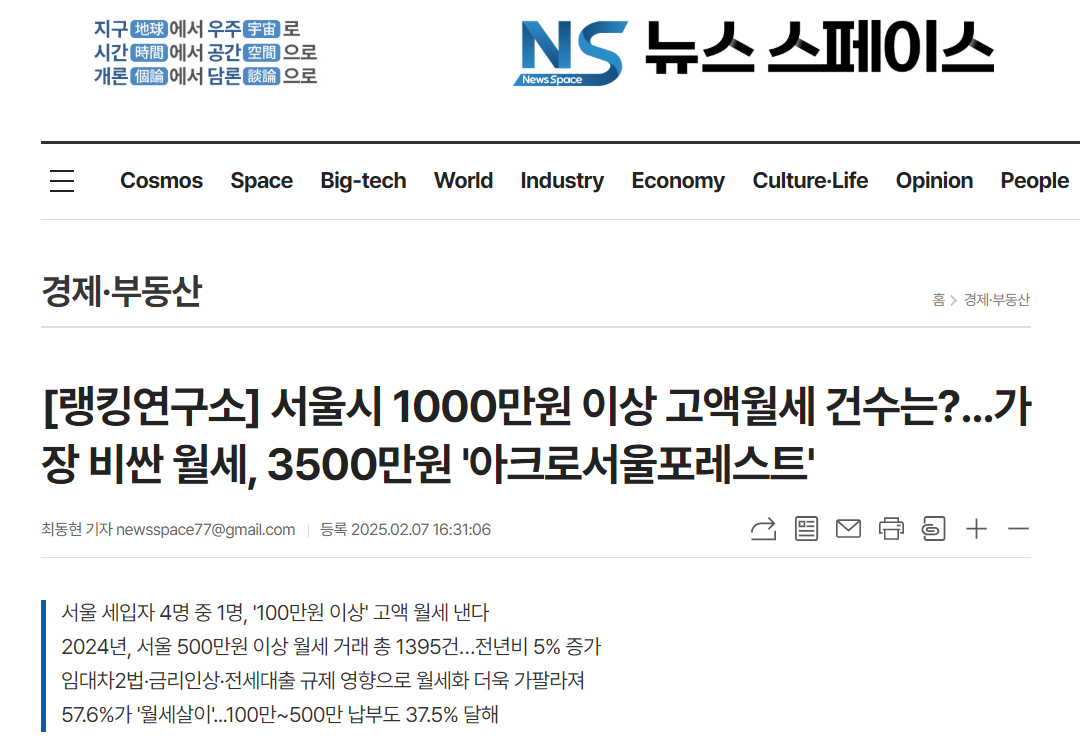

### 공공임대주택, 민간 공공임대주택, 행복주택, 청년주택등의 매물은 이상치라 판단가능하여 여러 방법으로 필터링 할 수 있는 방법을 모색하였지만 명확한 구분이 어렵고 이후 모델의 성능을 확인하고 추가하는 것으로

1. 임대주택에 대해서 계약기간이 길 것이라는 전제로 특정 계약기간을 기준으로 월세금의 평균을 비교하여 전후 평균의 차이가 크면 임대주택으로 산정 ->
2. 보증금 5000만원 이하 월세 20만원 이하 인 경우 -> 공공 임대가 아닌 경우도 많음
3. lh, sh등을 포함하는 경우 필터링 -> 민간 임대, 공공임대 주택의 이름이 다양하고 모든 데이터에 정식이름으로 기제된 것은 아님

In [ ]:
display(df_apt.head())
display(df_vil.head())

,NO,시군구,번지,본번,부번,단지명,전월세구분,전용면적(㎡),계약년월,계약일,...,월세금(만원),층,건축년도,도로명,계약기간,계약구분,갱신요구권 사용,종전계약 보증금(만원),종전계약 월세(만원),주택유형
0,1,서울특별시 광진구 광장동,554-7,554,7,현대5,전세,84.53,202412,31,...,0,7,1989,아차산로70길 61,202504~202704,신규,-,NaN,NaN,아파트
1,2,서울특별시 광진구 광장동,218-1,218,1,극동2,전세,75.55,202412,31,...,0,8,1989,아차산로 552,202502~202702,신규,-,NaN,NaN,아파트
2,3,서울특별시 성동구 금호동2가,1,1,0,신금호파크자이,월세,84.98,202412,31,...,80,12,2016,금호로 173,202502~202702,신규,-,NaN,NaN,아파트
3,4,서울특별시 성동구 행당동,375,375,0,행당두산위브,전세,59.99,202412,31,...,0,6,2009,행당로8길 8,202503~202703,신규,-,NaN,NaN,아파트
4,5,서울특별시 성동구 행당동,380,380,0,서울숲리버뷰자이,월세,84.90,202412,31,...,120,22,2018,고산자로2길 65,202502~202702,신규,-,NaN,NaN,아파트


,NO,시군구,번지,본번,부번,건물명,전월세구분,전용면적(㎡),계약년월,계약일,...,월세금(만원),층,건축년도,도로명,계약기간,계약구분,갱신요구권 사용,종전계약 보증금(만원),종전계약 월세(만원),주택유형
0,1,서울특별시 용산구 원효로1가,120-22,120,22,용산2차휴먼타운,전세,27.24,202412,31,...,0,4,2018,백범로90라길 38,202503~202703,신규,-,NaN,NaN,연립다세대
1,2,서울특별시 광진구 광장동,413-15,413,15,시원빌라,월세,48.78,202412,31,...,90,2,1992,아차산로69길 14,202502~202702,신규,-,NaN,NaN,연립다세대
2,3,서울특별시 종로구 연건동,45-7,45,7,(45-7),월세,17.33,202412,31,...,50,4,2000,대학로5길 52-1,202502~202702,신규,-,NaN,NaN,연립다세대
3,4,서울특별시 용산구 한강로1가,218-2,218,2,아인하우스1차(218-2),월세,16.21,202412,31,...,50,2,2018,한강대로62길 68,202502~202702,신규,-,NaN,NaN,연립다세대
4,5,서울특별시 광진구 구의동,207-4,207,4,오아시스빌,월세,42.83,202412,31,...,20,3,2003,구의로4길 69-5,202502~202702,신규,-,NaN,NaN,연립다세대


In [ ]:
combined = pd.concat([df_apt, df_vil], ignore_index=True)

In [ ]:
print(len(df_apt))
print(len(df_vil))

In [ ]:
print(len(df_apt))
print(len(df_vil))

162756
106422


In [ ]:
combined.to_csv("/content/drive/MyDrive/DataMining/term project/data/OG/apt_vil_combined.csv", index=False)

In [ ]:
combined['도로명'] = combined['시군구']+combined['번지']

In [ ]:
combined['도로명']

In [ ]:
print(len(df_apt))
print(len(df_vil))

162756
106422


In [ ]:
combined['도로명']

,도로명
0,서울특별시 광진구 광장동554-7
1,서울특별시 광진구 광장동218-1
2,서울특별시 성동구 금호동2가1
3,서울특별시 성동구 행당동375
4,서울특별시 성동구 행당동380
...,...
269173,서울특별시 금천구 가산동237-96
269174,서울특별시 구로구 구로동486-29
269175,서울특별시 금천구 독산동1064-26
269176,서울특별시 금천구 시흥동886


In [ ]:
combined.isna().sum()

,0
NO,0
시군구,0
번지,0
본번,0
부번,0
단지명,106422
전월세구분,0
전용면적(㎡),0
계약년월,0
계약일,0


In [ ]:
com = combined.drop(['단지명','NO','종전계약 보증금(만원)','종전계약 월세(만원)'], axis=1)
com.head()

,시군구,번지,본번,부번,전월세구분,전용면적(㎡),계약년월,계약일,보증금(만원),월세금(만원),층,건축년도,도로명,계약기간,계약구분,갱신요구권 사용,주택유형,건물명
0,서울특별시 광진구 광장동,554-7,554,7,전세,84.53,202412,31,"74,000",0,7,1989,서울특별시 광진구 광장동554-7,202504~202704,신규,-,아파트,NaN
1,서울특별시 광진구 광장동,218-1,218,1,전세,75.55,202412,31,"54,000",0,8,1989,서울특별시 광진구 광장동218-1,202502~202702,신규,-,아파트,NaN
2,서울특별시 성동구 금호동2가,1,1,0,월세,84.98,202412,31,"75,000",80,12,2016,서울특별시 성동구 금호동2가1,202502~202702,신규,-,아파트,NaN
3,서울특별시 성동구 행당동,375,375,0,전세,59.99,202412,31,"70,000",0,6,2009,서울특별시 성동구 행당동375,202503~202703,신규,-,아파트,NaN
4,서울특별시 성동구 행당동,380,380,0,월세,84.90,202412,31,"70,000",120,22,2018,서울특별시 성동구 행당동380,202502~202702,신규,-,아파트,NaN


In [ ]:
com['계약일'].unique()

array([31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [ ]:
com['계약년월'].unique()

array([202412, 202411, 202410, 202409, 202408, 202407, 202406, 202405,
       202404, 202403, 202402, 202401])

In [ ]:
# 1. '시군구' 분리
com['시'] = com['시군구'].str.split(expand=True)[0]
com['구'] = com['시군구'].str.split(expand=True)[1]
com['동'] = com['시군구'].str.split(expand=True)[2]

# 2. 보증금, 월세금에서 ',' 제거 후 int로 변환
com['보증금(만원)'] = com['보증금(만원)'].astype(str).str.replace(',', '', regex=False).astype(int)
com['월세금(만원)'] = com['월세금(만원)'].astype(str).str.replace(',', '', regex=False).astype(int)

# 3. 계약년월 → 계약년, 계약월 분리
com['계약년'] = com['계약년월'].astype(str).str[:4].astype(int)
com['계약월'] = com['계약년월'].astype(str).str[4:].astype(int)
com.head()

,시군구,번지,본번,부번,전월세구분,전용면적(㎡),계약년월,계약일,보증금(만원),월세금(만원),...,계약기간,계약구분,갱신요구권 사용,주택유형,건물명,시,구,동,계약년,계약월
0,서울특별시 광진구 광장동,554-7,554,7,전세,84.53,202412,31,74000,0,...,202504~202704,신규,-,아파트,현대5,서울특별시,광진구,광장동,2024,12
1,서울특별시 광진구 광장동,218-1,218,1,전세,75.55,202412,31,54000,0,...,202502~202702,신규,-,아파트,극동2,서울특별시,광진구,광장동,2024,12
2,서울특별시 성동구 금호동2가,1,1,0,월세,84.98,202412,31,75000,80,...,202502~202702,신규,-,아파트,신금호파크자이,서울특별시,성동구,금호동2가,2024,12
3,서울특별시 성동구 행당동,375,375,0,전세,59.99,202412,31,70000,0,...,202503~202703,신규,-,아파트,행당두산위브,서울특별시,성동구,행당동,2024,12
4,서울특별시 성동구 행당동,380,380,0,월세,84.90,202412,31,70000,120,...,202502~202702,신규,-,아파트,서울숲리버뷰자이,서울특별시,성동구,행당동,2024,12


In [ ]:
com.drop(['계약구분','갱신요구권 사용','시군구','계약년월','번지','본번','부번'],axis=1, inplace=True)
print(com.info())
display(com.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269178 entries, 0 to 269177
Data columns (total 16 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   전월세구분    269178 non-null  object 
 1   전용면적(㎡)  269178 non-null  float64
 2   계약일      269178 non-null  int64  
 3   보증금(만원)  269178 non-null  int64  
 4   월세금(만원)  269178 non-null  int64  
 5   층        269178 non-null  int64  
 6   건축년도     269178 non-null  int64  
 7   도로명      269178 non-null  object 
 8   계약기간     269178 non-null  object 
 9   주택유형     269178 non-null  object 
 10  건물명      269177 non-null  object 
 11  시        269178 non-null  object 
 12  구        269178 non-null  object 
 13  동        269178 non-null  object 
 14  계약년      269178 non-null  int64  
 15  계약월      269178 non-null  int64  
dtypes: float64(1), int64(7), object(8)
memory usage: 32.9+ MB
None


,전월세구분,전용면적(㎡),계약일,보증금(만원),월세금(만원),층,건축년도,도로명,계약기간,주택유형,건물명,시,구,동,계약년,계약월
0,전세,84.53,31,74000,0,7,1989,서울특별시 광진구 광장동554-7,202504~202704,아파트,현대5,서울특별시,광진구,광장동,2024,12
1,전세,75.55,31,54000,0,8,1989,서울특별시 광진구 광장동218-1,202502~202702,아파트,극동2,서울특별시,광진구,광장동,2024,12
2,월세,84.98,31,75000,80,12,2016,서울특별시 성동구 금호동2가1,202502~202702,아파트,신금호파크자이,서울특별시,성동구,금호동2가,2024,12
3,전세,59.99,31,70000,0,6,2009,서울특별시 성동구 행당동375,202503~202703,아파트,행당두산위브,서울특별시,성동구,행당동,2024,12
4,월세,84.90,31,70000,120,22,2018,서울특별시 성동구 행당동380,202502~202702,아파트,서울숲리버뷰자이,서울특별시,성동구,행당동,2024,12


In [ ]:
com = com[com['계약기간'] != '-']


In [ ]:
# 계약기간을 시작과 종료로 나누기
com[['계약시작', '계약종료']] = com['계약기간'].str.split('~', expand=True)

# 연도와 월로 분리
com['시작연'] = com['계약시작'].str[:4].astype(int)
com['시작월'] = com['계약시작'].str[4:].astype(int)
com['종료연'] = com['계약종료'].str[:4].astype(int)
com['종료월'] = com['계약종료'].str[4:].astype(int)

# 개월 수 계산
com['계약개월수'] = (com['종료연'] - com['시작연']) * 12 + (com['종료월'] - com['시작월'])

# 사용한 컬럼 제거하고 계약기간을 계약개월수로 대체하려면:
# com.drop(columns=['계약기간', '계약시작', '계약종료', '시작연', '시작월', '종료연', '종료월'], inplace=True)
com.head()

,전월세구분,전용면적(㎡),계약일,보증금(만원),월세금(만원),층,건축년도,도로명,계약기간,주택유형,...,동,계약년,계약월,계약시작,계약종료,시작연,시작월,종료연,종료월,계약개월수
0,전세,84.53,31,74000,0,7,1989,서울특별시 광진구 광장동554-7,202504~202704,아파트,...,광장동,2024,12,202504,202704,2025,4,2027,4,24
1,전세,75.55,31,54000,0,8,1989,서울특별시 광진구 광장동218-1,202502~202702,아파트,...,광장동,2024,12,202502,202702,2025,2,2027,2,24
2,월세,84.98,31,75000,80,12,2016,서울특별시 성동구 금호동2가1,202502~202702,아파트,...,금호동2가,2024,12,202502,202702,2025,2,2027,2,24
3,전세,59.99,31,70000,0,6,2009,서울특별시 성동구 행당동375,202503~202703,아파트,...,행당동,2024,12,202503,202703,2025,3,2027,3,24
4,월세,84.90,31,70000,120,22,2018,서울특별시 성동구 행당동380,202502~202702,아파트,...,행당동,2024,12,202502,202702,2025,2,2027,2,24


In [ ]:
com['계약시작'].unique()

array(['202504', '202502', '202503', '202501', '-', '202505', '202412',
       '202311', '202402', '202411', '202406', '202408', '202403',
       '202508', '202303', '202401', '202409', '202308', '202410',
       '202011', '202506', '202310', '202405', '202407', '202309',
       '202302', '202404', '202507', '202312', '200502', '202111',
       '202512', '202201', '202211', '202305', '202510', '202306',
       '201610', '202509', '202307', '202205', '202212', '202304',
       '202301', '202209', '200404', '202204', '202005', '202105',
       '202207', '202103', '202004', '202203', '202210', '200408',
       '202110', '202601', '201501', '201910', '201411', '202511',
       '202609', '202102', '202608', '201711', '202606', '202208',
       '202206', '201903', '202604', '201812', '202112', '202605',
       '201904', '202003', '201404', '201402'], dtype=object)

In [ ]:
com['계약시작'].unique()

array(['202504', '202502', '202503', '202501', '-', '202505', '202412',
       '202311', '202402', '202411', '202406', '202408', '202403',
       '202508', '202303', '202401', '202409', '202308', '202410',
       '202011', '202506', '202310', '202405', '202407', '202309',
       '202302', '202404', '202507', '202312', '200502', '202111',
       '202512', '202201', '202211', '202305', '202510', '202306',
       '201610', '202509', '202307', '202205', '202212', '202304',
       '202301', '202209', '200404', '202204', '202005', '202105',
       '202207', '202103', '202004', '202203', '202210', '200408',
       '202110', '202601', '201501', '201910', '201411', '202511',
       '202609', '202102', '202608', '201711', '202606', '202208',
       '202206', '201903', '202604', '201812', '202112', '202605',
       '201904', '202003', '201404', '201402'], dtype=object)

In [ ]:
com['계약년'].unique()

array([2024])

In [ ]:
com =com[(com['계약년']<=com['시작연'])]

In [ ]:
com['전월세구분'].unique()

array(['전세', '월세'], dtype=object)

In [ ]:
com = com[com['전월세구분']=="월세"]

In [ ]:
com = com[com['월세금(만원)']!=0]

In [ ]:
com.describe()

,전용면적(㎡),계약일,보증금(만원),월세금(만원),층,건축년도,계약년,계약월,시작연,시작월,종료연,종료월,계약개월수
count,122474.000000,122474.000000,122474.000000,122474.000000,122474.000000,122474.000000,122474.0,122474.000000,122474.000000,122474.000000,122474.000000,122474.000000,122474.000000
mean,48.399161,15.921918,13620.642683,93.816263,6.499249,2007.934288,2024.0,6.374700,2024.108488,6.206158,2026.050803,6.154939,23.256552
std,29.968256,8.810877,19855.398132,109.803801,5.780149,11.762594,0.0,3.532878,0.311181,3.481751,23.090786,3.491874,277.088032
min,7.180000,1.000000,0.000000,1.000000,-2.000000,1956.000000,2024.0,1.000000,2024.000000,1.000000,2024.000000,1.000000,0.000000
25%,26.240000,8.000000,2000.000000,39.000000,3.000000,2000.000000,2024.0,3.000000,2024.000000,3.000000,2026.000000,3.000000,24.000000
50%,41.384100,16.000000,6000.000000,65.000000,4.000000,2011.000000,2024.0,6.000000,2024.000000,6.000000,2026.000000,6.000000,24.000000
75%,59.990000,24.000000,19000.000000,110.000000,9.000000,2018.000000,2024.0,10.000000,2024.000000,9.000000,2026.000000,9.000000,24.000000
max,329.250000,31.000000,500000.000000,3500.000000,69.000000,2025.000000,2024.0,12.000000,2026.000000,12.000000,9999.000000,12.000000,95708.000000


### 월세금 분포 확인

<Axes: ylabel='월세금(만원)'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE W

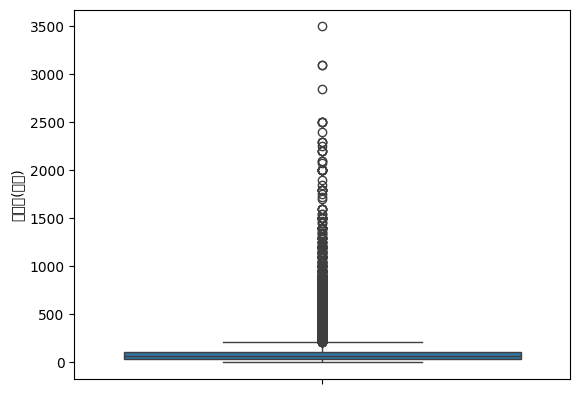

In [ ]:
import seaborn as sns
sns.boxplot(com['월세금(만원)'])

In [ ]:
com['월부담액'] = com['보증금(만원)']*0.04/12+com['월세금(만원)']

In [ ]:
print(f"5년 이하 평균 월세가격 평균 : {com[(com['계약개월수']<=60)]['월세금(만원)'].mean()}")
print(f"5년 초과 평균 월세가격 평균 : {com[(com['계약개월수']>60)]['월세금(만원)'].mean()}")

5년 이하 평균 월세가격 평균 : 93.8044355167965
5년 초과 평균 월세가격 평균 : 109.95


In [ ]:
com['월부담액'] = com['보증금(만원)']*0.04/12+com['월세금(만원)']

In [ ]:
com[['월세금(만원)','월부담액']].describe()

,월세금(만원),월부담액
count,122474.000000,122474.000000
mean,93.816263,139.218405
std,109.803801,138.546048
min,1.000000,3.000000
25%,39.000000,64.333333
50%,65.000000,91.666667
75%,110.000000,161.666667
max,3500.000000,3511.666667


In [ ]:
# com.drop('계약기간',axis=1, inplace=True)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


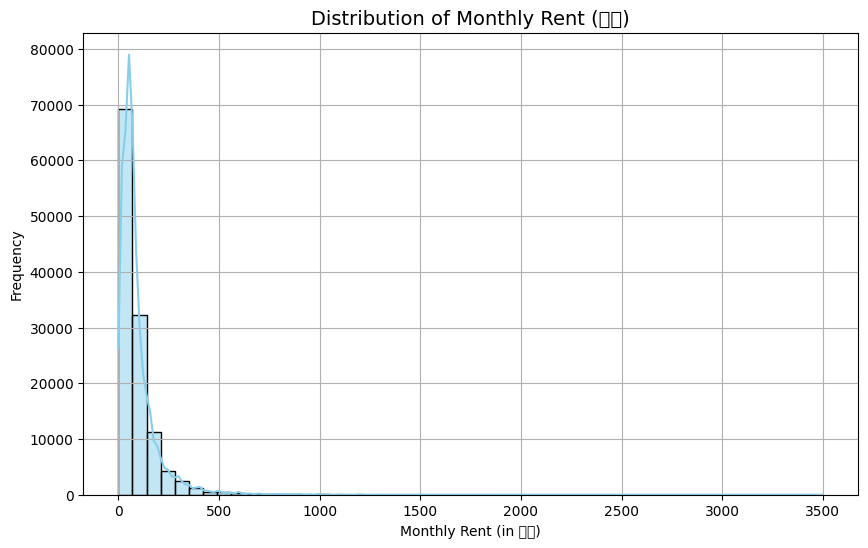

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(com['월세금(만원)'], bins=50, kde=True, color='skyblue')

plt.title("Distribution of Monthly Rent (만원)", fontsize=14)
plt.xlabel("Monthly Rent (in 만원)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### 5년을 기준으로 월세금 분포확인

<ipython-input-73-852eac7c68df>:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_5years_or_less.dropna(), data_over_5years.dropna()],


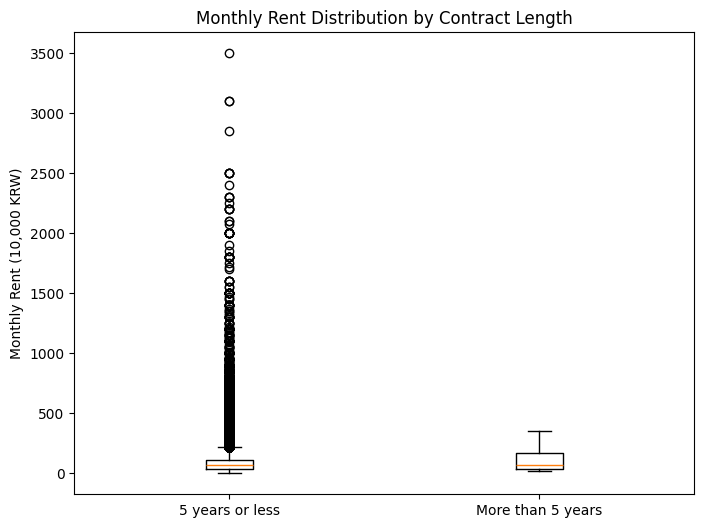

In [ ]:
import matplotlib.pyplot as plt

data_5years_or_less = com[com['계약개월수'] <= 60]['월세금(만원)']
data_over_5years = com[com['계약개월수'] > 60]['월세금(만원)']

plt.figure(figsize=(8,6))
plt.boxplot([data_5years_or_less.dropna(), data_over_5years.dropna()],
            labels=['5 years or less', 'More than 5 years'])
plt.title('Monthly Rent Distribution by Contract Length')
plt.ylabel('Monthly Rent (10,000 KRW)')
plt.show()

In [ ]:
from google.colab import userdata
KAKAO_REST_API_KEY = userdata.get('KAKAO_REST_API_KEY')

In [ ]:
import requests
import pandas as pd
import time

def get_lat_lng(address):
    url = 'https://dapi.kakao.com/v2/local/search/address.json'
    headers = {"Authorization": f"KakaoAK {KAKAO_REST_API_KEY}"}
    params = {"query": address}

    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        result = response.json()
        if result['documents']:
            location = result['documents'][0]['address']
            return float(location['y']), float(location['x'])  # 위도, 경도
    return None, None

# 1. 고유한 도로명 주소 리스트 추출
unique_addresses = com['도로명'].dropna().unique()

# 2. 주소별 위도/경도 저장 딕셔너리
address_to_latlng = {}

for addr in unique_addresses:
    lat, lng = get_lat_lng(addr)
    address_to_latlng[addr] = (lat, lng)
    time.sleep(0.2)  # API 과다 호출 방지

# 3. 원래 데이터프레임에 위도/경도 추가
com['위도'] = com['도로명'].map(lambda x: address_to_latlng.get(x, (None, None))[0])
com['경도'] = com['도로명'].map(lambda x: address_to_latlng.get(x, (None, None))[1])

In [ ]:
com.head()

,전월세구분,전용면적(㎡),계약일,보증금(만원),월세금(만원),층,건축년도,도로명,주택유형,건물명,...,계약시작,계약종료,시작연,시작월,종료연,종료월,계약개월수,월부담액,위도,경도
2,월세,84.9800,31,75000,80,12,2016,서울특별시 성동구 금호동2가1,아파트,신금호파크자이,...,202502,202702,2025,2,2027,2,24,330.000000,37.555446,127.018621
4,월세,84.9000,31,70000,120,22,2018,서울특별시 성동구 행당동380,아파트,서울숲리버뷰자이,...,202502,202702,2025,2,2027,2,24,353.333333,37.555141,127.038383
6,월세,84.8800,31,10000,215,9,2002,서울특별시 중구 신당동844,아파트,남산타운,...,202502,202702,2025,2,2027,2,24,248.333333,37.548681,127.008880
8,월세,84.8359,31,10000,425,12,2017,서울특별시 종로구 평동233,아파트,경희궁자이(3단지),...,202502,202702,2025,2,2027,2,24,458.333333,37.568469,126.965891
11,월세,15.5500,31,1000,75,10,2014,서울특별시 중구 흥인동119,아파트,동대문와이즈캐슬,...,202502,202702,2025,2,2027,2,24,78.333333,37.565842,127.015468


In [ ]:
com.columns

Index(['전월세구분', '전용면적(㎡)', '계약일', '보증금(만원)', '월세금(만원)', '층', '건축년도', '도로명',
       '주택유형', '건물명', '시', '구', '동', '계약년', '계약월', '계약시작', '계약종료', '시작연',
       '시작월', '종료연', '종료월', '계약개월수', '월부담액', '위도', '경도'],
      dtype='object')

In [ ]:
com.drop(['계약시작','계약종료','시'],axis=1, inplace=True)

In [ ]:
com[['월세금(만원)','월부담액']].describe()

,월세금(만원),월부담액
count,122474.000000,122474.000000
mean,93.816263,139.218405
std,109.803801,138.546048
min,1.000000,3.000000
25%,39.000000,64.333333
50%,65.000000,91.666667
75%,110.000000,161.666667
max,3500.000000,3511.666667


In [ ]:
# com.drop('계약기간',axis=1, inplace=True)

In [ ]:
df.isna().sum()

,0
전월세구분,0
전용면적(㎡),0
계약일,0
보증금(만원),0
월세금(만원),0
층,0
건축년도,0
도로명,0
주택유형,0
건물명,1


In [ ]:
df[df['위도'].isna()]['도로명']

,도로명
72,서울특별시 강남구 개포동1284
350,서울특별시 강남구 개포동1284
770,서울특별시 강동구 고덕동BL-3-1
901,서울특별시 강남구 개포동1284
1105,서울특별시 강북구 미아동1375
...,...
115319,서울특별시 도봉구 창동601-19
116751,서울특별시 송파구 오금동130
119566,서울특별시 노원구 공릉동503-1
119955,서울특별시 금천구 가산동237-67


In [ ]:
from google.colab import userdata
KAKAO_REST_API_KEY = userdata.get('KAKAO_REST_API_KEY')

In [ ]:
df_no = pd.DataFrame(df[df['위도'].isna()]['도로명'])

In [ ]:
import requests
import pandas as pd
import time


def get_lat_lng(address):
    url = 'https://dapi.kakao.com/v2/local/search/address.json'
    headers = {"Authorization": f"KakaoAK {KAKAO_REST_API_KEY}"}
    params = {"query": address}

    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        result = response.json()
        if result['documents']:
            location = result['documents'][0]['address']
            return float(location['y']), float(location['x'])  # 위도, 경도
    return None, None

# 1. 고유한 도로명 주소 리스트 추출
unique_addresses = df_no['도로명'].unique()

# 2. 주소별 위도/경도 저장 딕셔너리
address_to_latlng = {}

for addr in unique_addresses:
    lat, lng = get_lat_lng(addr)
    address_to_latlng[addr] = (lat, lng)
    time.sleep(0.2)  # API 과다 호출 방지

# 3. 원래 데이터프레임에 위도/경도 추가
df_no['위도'] = df_no['도로명'].map(lambda x: address_to_latlng.get(x, (None, None))[0])
df_no['경도'] = df_no['도로명'].map(lambda x: address_to_latlng.get(x, (None, None))[1])

In [ ]:
df_no[(df_no['위도'].notnull())&(df_no['경도'].notnull())]

,도로명,위도,경도
2279,서울특별시 중구 황학동2523,37.566172,127.021909
2465,서울특별시 강남구 개포동1280,37.481171,127.064887
2746,서울특별시 성북구 정릉동239-5,37.615996,127.007267
3105,서울특별시 송파구 거여동696,37.493902,127.150147
3470,서울특별시 서초구 서초동1315,37.497346,127.022614
...,...,...,...
115319,서울특별시 도봉구 창동601-19,37.640573,127.039129
116751,서울특별시 송파구 오금동130,37.502708,127.138819
119566,서울특별시 노원구 공릉동503-1,37.625997,127.075740
119955,서울특별시 금천구 가산동237-67,37.473078,126.889478


In [ ]:
# 위도와 경도가 모두 존재하는 행만 필터링
filtered_df = df_no[(df_no['위도'].notnull()) & (df_no['경도'].notnull())]

# 딕셔너리 생성: {'도로명': (위도, 경도)}
location_dict = dict(zip(filtered_df['도로명'], zip(filtered_df['위도'], filtered_df['경도'])))

In [ ]:
# 위도 또는 경도가 NaN인 행의 인덱스를 찾기
mask = df['위도'].isna() | df['경도'].isna()

# 해당 행에 대해서만 도로명 기준으로 위도, 경도 값 업데이트
df.loc[mask, '위도'] = df.loc[mask, '도로명'].map(lambda x: location_dict.get(x, (None, None))[0])
df.loc[mask, '경도'] = df.loc[mask, '도로명'].map(lambda x: location_dict.get(x, (None, None))[1])

In [ ]:
df.isna().sum()

,0
전월세구분,0
전용면적(㎡),0
계약일,0
보증금(만원),0
월세금(만원),0
층,0
건축년도,0
도로명,0
주택유형,0
건물명,1


In [ ]:
df = df[(df['위도'].notnull())|(df['경도'].notnull())]

In [ ]:
df.isna().sum()

,0
전월세구분,0
전용면적(㎡),0
계약일,0
보증금(만원),0
월세금(만원),0
층,0
건축년도,0
도로명,0
주택유형,0
건물명,1


In [ ]:
df.to_csv("/content/drive/MyDrive/DataMining/term project/data/OG/전처리_위경도추가.csv",index=False)

### 보증금, 월세 시각화

<Axes: xlabel='보증금(만원)', ylabel='월세금(만원)'>

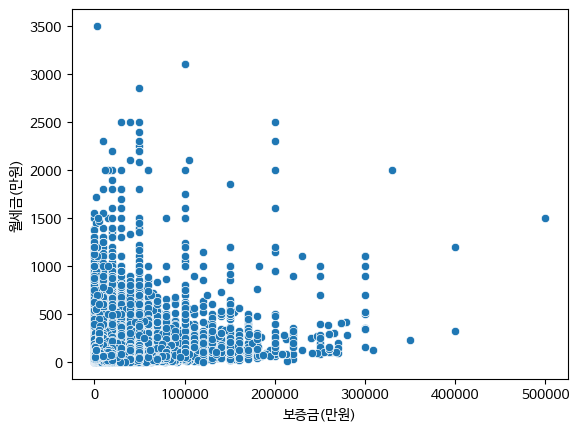

In [ ]:
import seaborn as sns
sns.scatterplot(x = df['보증금(만원)'],y=df['월세금(만원)'])

<Axes: xlabel='보증금(만원)', ylabel='월세금(만원)'>

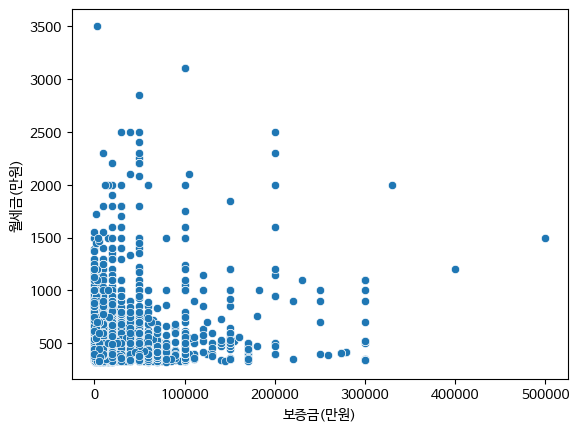

In [ ]:
df_ma = df[df['월세금(만원)']>320]
sns.scatterplot(x = df_ma['보증금(만원)'],y=df_ma['월세금(만원)'])

<Axes: xlabel='보증금(만원)', ylabel='월세금(만원)'>

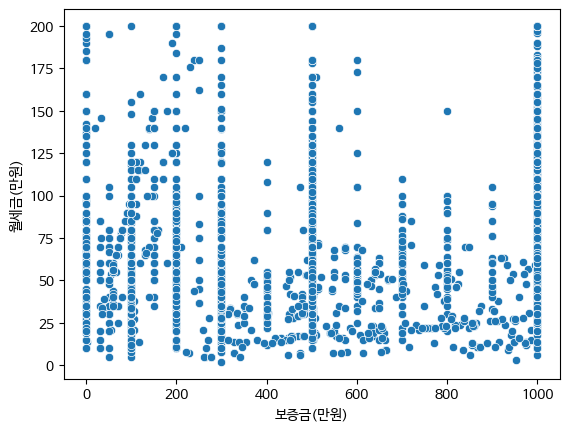

In [ ]:
df_ma = df00[(df00['월세금(만원)']<=200)&(df00['보증금(만원)']<=1000)]
sns.scatterplot(x = df_ma['보증금(만원)'],y=df_ma['월세금(만원)'])

<Axes: xlabel='보증금(만원)', ylabel='월세금(만원)'>

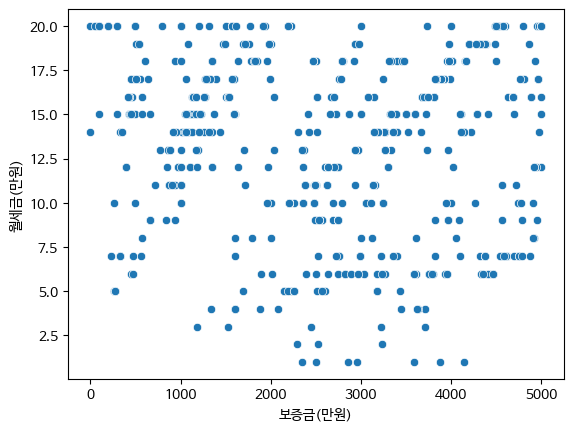

In [ ]:
df_ma = df00[(df00['월세금(만원)']<=20)&(df00['보증금(만원)']<=5000)&(df00['주택유형']=='아파트')]
sns.scatterplot(x = df_ma['보증금(만원)'],y=df_ma['월세금(만원)'])

### ```월세금(만원)<=20``` 이고 ```보증금(만원)<=5000```, 아파트인 경우

In [ ]:
df_masked = df00[(df00['월세금(만원)']<=20)&(df00['보증금(만원)']<=5000)&(df00['주택유형']=='아파트')]
df_masked.head()

,전월세구분,전용면적(㎡),계약일,보증금(만원),월세금(만원),층,건축년도,도로명,주택유형,건물명,...,시작연,시작월,종료연,종료월,계약개월수,월부담액,위도,경도,보증금/월세금,월세금/면적
200,월세,14.69,30,4968,17,7,2024,서울특별시 강남구 자곡동138-2,아파트,LH수서2단지아파트,...,2024,12,2027,2,26,33.56,37.478904,127.107706,292.235294,0.86
220,월세,14.69,30,4692,16,10,2024,서울특별시 강남구 자곡동138-2,아파트,LH수서2단지아파트,...,2024,12,2027,2,26,31.64,37.478904,127.107706,293.250000,0.92
221,월세,14.69,30,4692,16,12,2024,서울특별시 강남구 자곡동138-2,아파트,LH수서2단지아파트,...,2024,12,2027,2,26,31.64,37.478904,127.107706,293.250000,0.92
224,월세,14.69,30,4140,14,2,2024,서울특별시 강남구 자곡동138-2,아파트,LH수서2단지아파트,...,2024,12,2027,2,26,27.80,37.478904,127.107706,295.714286,1.05
225,월세,14.69,30,4692,16,9,2024,서울특별시 강남구 자곡동138-2,아파트,LH수서2단지아파트,...,2024,12,2027,2,26,31.64,37.478904,127.107706,293.250000,0.92


In [ ]:
df_inv_masked = df00[(df00['월세금(만원)']>20)&(df00['보증금(만원)']>5000)&(df00['주택유형']=='아파트')]
df_inv_masked.head()

,전월세구분,전용면적(㎡),계약일,보증금(만원),월세금(만원),층,건축년도,도로명,주택유형,건물명,...,시작연,시작월,종료연,종료월,계약개월수,월부담액,위도,경도,보증금/월세금,월세금/면적
0,월세,84.9800,31,75000,80,12,2016,서울특별시 성동구 금호동2가1,아파트,신금호파크자이,...,2025,2,2027,2,24,330.00,37.555446,127.018621,937.500000,1.06
1,월세,84.9000,31,70000,120,22,2018,서울특별시 성동구 행당동380,아파트,서울숲리버뷰자이,...,2025,2,2027,2,24,353.33,37.555141,127.038383,583.333333,0.71
2,월세,84.8800,31,10000,215,9,2002,서울특별시 중구 신당동844,아파트,남산타운,...,2025,2,2027,2,24,248.33,37.548681,127.008880,46.511628,0.39
3,월세,84.8359,31,10000,425,12,2017,서울특별시 종로구 평동233,아파트,경희궁자이(3단지),...,2025,2,2027,2,24,458.33,37.568469,126.965891,23.529412,0.20
5,월세,84.8900,31,60000,130,6,1998,서울특별시 용산구 이촌동404,아파트,한가람,...,2025,2,2027,2,24,330.00,37.521585,126.970287,461.538462,0.65


In [ ]:
print(df_masked['보증금/월세금'].mean())
print(df_inv_masked['보증금/월세금'].mean())

274.32932205305883
322.3135131098503


In [ ]:
print(df_masked['월세금/면적'].mean())
print(df_inv_masked['월세금/면적'].mean())

2.39842050209205
0.710383178124444


In [ ]:
print(df_masked['월부담액'].mean())
print(df_inv_masked['월부담액'].mean())

23.271108786610878
263.4117429859422


In [ ]:
df_m = df00[(df00['월세금(만원)']<=20)&(df00['보증금(만원)']<=5000)]
df_i_m = df00[(df00['월세금(만원)']>20)&(df00['보증금(만원)']>5000)]

In [ ]:
print(df_m['보증금/월세금'].mean())
print(df_i_m['보증금/월세금'].mean())
print('--------------')
print(df_m['월세금/면적'].mean())
print(df_i_m['월세금/면적'].mean())
print('--------------')
print(df_m['월부담액'].mean())
print(df_i_m['월부담액'].mean())

262.79815915658605
341.9816865122673
--------------
2.7043925831202045
0.7961570434820063
--------------
22.7753452685422
220.42504662632183


### 이름으로 공공임대주택 필터링 시도

In [ ]:
df[df['건물명'].str.lower().str.contains('lh|sh', na=False)]['건물명'].unique()

array(['LH서울잠실행복주택', 'LH수서2단지아파트', 'LH서울양원1단지', 'DasHaus', 'SH대치1단지아파트',
       '불광SH빌', '당산SHVILLE', 'SH하우스', 'JSHAUS', 'BETHELHOUSE', '희망(WISH)',
       'BLESSHOME', "Mook'sHAUS(52-17)", 'WISH희망', 'LaHShouse',
       'SH초행지붕-화곡', 'TJSH', 'HillHouse', 'SH팰리스', 'GardenHealsHouse',
       'GreenhillHouse', 'J/SHome', 'sheeltower', 'LH석촌도시형생활주택',
       'HILLHOUSE1', 'shinehouse', 'PhilHeim', 'ImmanuelHouse', 'SH스카이',
       'LH(179-2)', '청담ShineVille', 'PLUSHOUSE'], dtype=object)

In [ ]:
lh_sh_list = ['LH서울잠실행복주택', 'LH수서2단지아파트', 'LH서울양원1단지', 'SH대치1단지아파트',
       '불광SH빌', '당산SHVILLE', 'SH하우스',
       'SH초행지붕-화곡', 'SH팰리스','J/SHome', 'LH석촌도시형생활주택', 'ImmanuelHouse',
       'LH(179-2)']

In [ ]:
df00['월부담액'] = df00['월부담액'].round(2)
df00['보증금/월세금'] = df00['보증금(만원)']/df00['월세금(만원)']
df00['보증금/월세금'].round(2)
df00['면적/월세금'] = df00['전용면적(㎡)']/df00['월세금(만원)']
df00['면적/월세금'] = df00['면적/월세금'].round(2)
df00.head()

<ipython-input-42-9b26b0591160>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df00['월부담액'] = df00['월부담액'].round(2)
<ipython-input-42-9b26b0591160>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df00['보증금/월세금'] = df00['보증금(만원)']/df00['월세금(만원)']
<ipython-input-42-9b26b0591160>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

,전월세구분,전용면적(㎡),계약일,보증금(만원),월세금(만원),층,건축년도,도로명,주택유형,건물명,...,시작연,시작월,종료연,종료월,계약개월수,월부담액,위도,경도,보증금/월세금,면적/월세금
0,월세,84.9800,31,75000,80,12,2016,서울특별시 성동구 금호동2가1,아파트,신금호파크자이,...,2025,2,2027,2,24,330.00,37.555446,127.018621,937.500000,1.06
1,월세,84.9000,31,70000,120,22,2018,서울특별시 성동구 행당동380,아파트,서울숲리버뷰자이,...,2025,2,2027,2,24,353.33,37.555141,127.038383,583.333333,0.71
2,월세,84.8800,31,10000,215,9,2002,서울특별시 중구 신당동844,아파트,남산타운,...,2025,2,2027,2,24,248.33,37.548681,127.008880,46.511628,0.39
3,월세,84.8359,31,10000,425,12,2017,서울특별시 종로구 평동233,아파트,경희궁자이(3단지),...,2025,2,2027,2,24,458.33,37.568469,126.965891,23.529412,0.20
4,월세,15.5500,31,1000,75,10,2014,서울특별시 중구 흥인동119,아파트,동대문와이즈캐슬,...,2025,2,2027,2,24,78.33,37.565842,127.015468,13.333333,0.21


In [ ]:
df00['월세금/면적'] = df00['월세금(만원)']/df00['전용면적(㎡)']
df00['월세금/면적'] = df00['면적/월세금'].round(2)
df00.drop(['면적/월세금'],axis=1,inplace=True)

<ipython-input-50-5e47ea4575bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df00['월세금/면적'] = df00['월세금(만원)']/df00['전용면적(㎡)']
<ipython-input-50-5e47ea4575bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df00['월세금/면적'] = df00['면적/월세금'].round(2)
<ipython-input-50-5e47ea4575bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [ ]:
df00.head()

,전월세구분,전용면적(㎡),계약일,보증금(만원),월세금(만원),층,건축년도,도로명,주택유형,건물명,...,시작연,시작월,종료연,종료월,계약개월수,월부담액,위도,경도,보증금/월세금,월세금/면적
0,월세,84.9800,31,75000,80,12,2016,서울특별시 성동구 금호동2가1,아파트,신금호파크자이,...,2025,2,2027,2,24,330.00,37.555446,127.018621,937.500000,1.06
1,월세,84.9000,31,70000,120,22,2018,서울특별시 성동구 행당동380,아파트,서울숲리버뷰자이,...,2025,2,2027,2,24,353.33,37.555141,127.038383,583.333333,0.71
2,월세,84.8800,31,10000,215,9,2002,서울특별시 중구 신당동844,아파트,남산타운,...,2025,2,2027,2,24,248.33,37.548681,127.008880,46.511628,0.39
3,월세,84.8359,31,10000,425,12,2017,서울특별시 종로구 평동233,아파트,경희궁자이(3단지),...,2025,2,2027,2,24,458.33,37.568469,126.965891,23.529412,0.20
4,월세,15.5500,31,1000,75,10,2014,서울특별시 중구 흥인동119,아파트,동대문와이즈캐슬,...,2025,2,2027,2,24,78.33,37.565842,127.015468,13.333333,0.21


In [ ]:
df00.head().T

,0,1,2,3,4
전월세구분,월세,월세,월세,월세,월세
전용면적(㎡),84.98,84.9,84.88,84.8359,15.55
계약일,31,31,31,31,31
보증금(만원),75000,70000,10000,10000,1000
월세금(만원),80,120,215,425,75
층,12,22,9,12,10
건축년도,2016,2018,2002,2017,2014
도로명,서울특별시 성동구 금호동2가1,서울특별시 성동구 행당동380,서울특별시 중구 신당동844,서울특별시 종로구 평동233,서울특별시 중구 흥인동119
주택유형,아파트,아파트,아파트,아파트,아파트
건물명,신금호파크자이,서울숲리버뷰자이,남산타운,경희궁자이(3단지),동대문와이즈캐슬


>>

# 지하철, 병원 위치 데이터를 이용하여 각 매물당 주변 개수 컬럼생성

### og_hos_pre, og_hos데이터 확인
### 역개수 추가 데이터 확인
### 식당, 병원, 파출소 데이터 확인
----------
### 병원 좌표계 위경도로 변경 후 BallTree알고리즘을 통해 매물의 위경도를 통해 거리 계산후 기준거리내 병원 개수 컬럼 생성

In [ ]:
import pandas as pd

# df = pd.read_csv("/content/drive/MyDrive/DataMining/term project/data/OG/og_hos.csv")
# hos_pre = pd.read_csv("/content/drive/MyDrive/DataMining/term project/data/OG/hos_pre.csv")
# rest = pd.read_excel("/content/drive/MyDrive/DataMining/term project/data/추가 데이터/07_24_01_P_관광식당.xlsx")
pol = pd.read_csv("/content/drive/MyDrive/DataMining/term project/data/추가 데이터/경찰청_전국 지구대 파출소 주소 현황_20231231.csv", encoding='cp949')
sub = pd.read_csv('/content/drive/MyDrive/DataMining/term project/data/추가 데이터/역 개수 추가.csv')
# ne_hos = pd.read_excel("/content/drive/MyDrive/DataMining/term project/data/추가 데이터/01_01_01_P_병원.xlsx")

In [ ]:
pop = pd.read_csv(
    "/content/drive/MyDrive/DataMining/term project/data/추가 데이터/201_DT_201003_A010006_20250525211807.csv",
    engine='python',         # 유연한 파서
    encoding='utf-8-sig',    # 혹은 'cp949', 파일 인코딩에 맞게 변경
    on_bad_lines='skip'      # 문제 있는 줄 건너뜀 (기존 error_bad_lines=False 대체)
)
\

In [ ]:
sub.head()

,전월세구분,전용면적(㎡),계약일,보증금(만원),월세금(만원),층,건축년도,도로명,주택유형,건물명,...,월부담액,위도,경도,보증금/월세금,월세금/면적,병원_1km내_개수,병원_3km내_개수,병원_10km내_개수,500m_이내_역_개수,1km_이내_역_개수
0,월세,84.9800,31,75000,80,12,2016,서울특별시 성동구 금호동2가1,아파트,신금호파크자이,...,330.00,37.555446,127.018621,937.500000,1.06,2,24,312,1,5
1,월세,84.9000,31,70000,120,22,2018,서울특별시 성동구 행당동380,아파트,서울숲리버뷰자이,...,353.33,37.555141,127.038383,583.333333,0.71,2,40,315,1,4
2,월세,84.8800,31,10000,215,9,2002,서울특별시 중구 신당동844,아파트,남산타운,...,248.33,37.548681,127.008880,46.511628,0.39,2,15,305,1,3
3,월세,84.8359,31,10000,425,12,2017,서울특별시 종로구 평동233,아파트,경희궁자이(3단지),...,458.33,37.568469,126.965891,23.529412,0.20,5,17,265,1,3
4,월세,15.5500,31,1000,75,10,2014,서울특별시 중구 흥인동119,아파트,동대문와이즈캐슬,...,78.33,37.565842,127.015468,13.333333,0.21,5,34,286,1,5


In [ ]:
hos_loc = pd.read_csv("/content/drive/MyDrive/DataMining/term project/data/추가 데이터/서울시 병의원 위치 정보.csv",encoding='cp949')
hos_loc.isna().sum()

,0
기관ID,0
주소,0
병원분류,0
병원분류명,0
응급의료기관코드,0
응급의료기관코드명,0
응급실운영여부(1/2),0
비고,117
기관설명상세,25
간이약도,1


In [ ]:
print(hos_loc['병원분류명'].unique())

['의원' '병원' '치과의원' '한방병원' '한의원' '치과병원' '요양병원' '종합병원' '기타' '보건소' '기타(구급차)']


In [ ]:
df.columns

Index(['전월세구분', '전용면적(㎡)', '계약일', '보증금(만원)', '월세금(만원)', '층', '건축년도', '도로명',
       '주택유형', '건물명', '구', '동', '계약년', '계약월', '시작연', '시작월', '종료연', '종료월',
       '계약개월수', '월부담액', '위도', '경도', '보증금/월세금', '월세금/면적', '병원_1km내_개수',
       '병원_3km내_개수', '병원_10km내_개수'],
      dtype='object')

In [ ]:
len(df)

122435

In [ ]:
len(sub)

122435

In [ ]:
sub.columns

Index(['전월세구분', '전용면적(㎡)', '계약일', '보증금(만원)', '월세금(만원)', '층', '건축년도', '도로명',
       '주택유형', '건물명', '구', '동', '계약년', '계약월', '시작연', '시작월', '종료연', '종료월',
       '계약개월수', '월부담액', '위도', '경도', '보증금/월세금', '월세금/면적', '500m_이내_역_개수',
       '1km_이내_역_개수'],
      dtype='object')

In [ ]:
df00 = sub.copy()

In [ ]:
import numpy as np
from sklearn.neighbors import BallTree

# 위경도 → 라디안 변환 (Haversine 거리 계산을 위해)
def to_radians(df, lat_col='위도', lon_col='경도'):
    return np.radians(df[[lat_col, lon_col]].values)

# 1km, 3km, 10km를 라디안으로 변환 (지구 반지름 약 6371km 기준)
radius_km = [0.2, 0.5, 1]
radii = [r / 6371.0 for r in radius_km]

# 매물 위치, 병원 위치를 라디안으로 변환
df00_rad = to_radians(df00, '위도', '경도')
hos00_rad = to_radians(hos_loc, '병원위도', '병원경도')

# BallTree 생성 (Haversine metric 사용)
tree = BallTree(hos00_rad, metric='haversine')

# 매물별 거리 내 병원 개수 계산
for r, km in zip(radii, radius_km):
    count = tree.query_radius(df00_rad, r=r, count_only=True)
    df00[f'병원_{km}km내_개수'] = count

In [ ]:
df00.columns

Index(['전월세구분', '전용면적(㎡)', '계약일', '보증금(만원)', '월세금(만원)', '층', '건축년도', '도로명',
       '주택유형', '건물명', '구', '동', '계약년', '계약월', '시작연', '시작월', '종료연', '종료월',
       '계약개월수', '월부담액', '위도', '경도', '보증금/월세금', '월세금/면적', '병원_1km내_개수',
       '병원_3km내_개수', '병원_10km내_개수', '500m_이내_역_개수', '1km_이내_역_개수',
       '병원_0.2km내_개수', '병원_0.5km내_개수'],
      dtype='object')

In [ ]:
df00.drop(['병원_0km내_개수','병원_5km내_개수'],axis=1)

In [ ]:
df00.head()

,전월세구분,전용면적(㎡),계약일,보증금(만원),월세금(만원),층,건축년도,도로명,주택유형,건물명,...,위도,경도,보증금/월세금,월세금/면적,500m_이내_역_개수,1km_이내_역_개수,병원_0.2km내_개수,병원_0km내_개수,병원_5km내_개수,병원_1km내_개수
0,월세,84.9800,31,75000,80,12,2016,서울특별시 성동구 금호동2가1,아파트,신금호파크자이,...,37.555446,127.018621,937.500000,1.06,1,5,16,0,4594,229
1,월세,84.9000,31,70000,120,22,2018,서울특별시 성동구 행당동380,아파트,서울숲리버뷰자이,...,37.555141,127.038383,583.333333,0.71,1,4,1,0,4618,137
2,월세,84.8800,31,10000,215,9,2002,서울특별시 중구 신당동844,아파트,남산타운,...,37.548681,127.008880,46.511628,0.39,1,3,0,0,4824,137
3,월세,84.8359,31,10000,425,12,2017,서울특별시 종로구 평동233,아파트,경희궁자이(3단지),...,37.568469,126.965891,23.529412,0.20,1,3,13,0,2823,192
4,월세,15.5500,31,1000,75,10,2014,서울특별시 중구 흥인동119,아파트,동대문와이즈캐슬,...,37.565842,127.015468,13.333333,0.21,1,5,16,0,3675,266


# 음식점 데이터 전처러
### 개방자치단체코드를 이용해 서울만 선택
### 여러 컬럼 제거
### 좌표정보, 도로명전체주소 둘다 없으면 drop
### 도로명전체주소 컬럼으로 좌표정보 추출
### 좌표정보 추출안된 200여개의 행 제거

In [ ]:
re = pd.read_csv("/content/drive/MyDrive/DataMining/term project/data/추가 데이터/fulldata_07_24_04_P_ Ϲ       .csv",encoding='cp949')

<ipython-input-39-ce1154073808>:1: DtypeWarning: Columns (11,39,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  re = pd.read_csv("/content/drive/MyDrive/DataMining/term project/data/추가 데이터/fulldata_07_24_04_P_ Ϲ       .csv",encoding='cp949')


In [ ]:
re.head()

,번호,개방서비스명,개방서비스아이디,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태구분코드,영업상태명,상세영업상태코드,...,공장생산직직원수,건물소유구분명,보증액,월세액,다중이용업소여부,시설총규모,전통업소지정번호,전통업소주된음식,홈페이지,Unnamed: 47
0,1,일반음식점,07_24_04_P,3250000,3250000-101-2024-00139,2024-12-02,NaN,3,폐업,2,...,0.0,NaN,0.0,0.0,N,0.0,NaN,NaN,NaN,NaN
1,2,일반음식점,07_24_04_P,3250000,3250000-101-2024-00138,2024-12-02,NaN,3,폐업,2,...,0.0,NaN,0.0,0.0,N,0.0,NaN,NaN,NaN,NaN
2,3,일반음식점,07_24_04_P,4070000,4070000-101-2024-00307,2024-12-02,NaN,3,폐업,2,...,0.0,NaN,0.0,0.0,N,18.0,NaN,NaN,NaN,NaN
3,4,일반음식점,07_24_04_P,3420000,3420000-101-2024-00355,2024-12-02,NaN,3,폐업,2,...,0.0,NaN,0.0,0.0,N,8.0,NaN,NaN,NaN,NaN
4,5,일반음식점,07_24_04_P,4311000,4311000-101-2025-00013,2025-01-06,NaN,3,폐업,2,...,0.0,NaN,0.0,0.0,N,0.0,NaN,NaN,NaN,NaN


In [ ]:
re['영업상태명'].unique()

array(['폐업', '영업/정상'], dtype=object)

In [ ]:
re = re[re['영업상태명']=='영업/정상']
re.head()

,번호,개방서비스명,개방서비스아이디,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태구분코드,영업상태명,상세영업상태코드,...,공장생산직직원수,건물소유구분명,보증액,월세액,다중이용업소여부,시설총규모,전통업소지정번호,전통업소주된음식,홈페이지,Unnamed: 47
1517800,1517801,일반음식점,07_24_04_P,3650000,3650000-101-2025-00003,2025-01-06,NaN,1,영업/정상,1,...,0.0,NaN,0.0,0.0,N,0.00,NaN,NaN,NaN,NaN
1517801,1517802,일반음식점,07_24_04_P,3530000,3530000-101-2024-00466,2024-12-02,NaN,1,영업/정상,1,...,0.0,NaN,0.0,0.0,N,29.75,NaN,NaN,NaN,NaN
1517802,1517803,일반음식점,07_24_04_P,3530000,3530000-101-2024-00465,2024-12-02,NaN,1,영업/정상,1,...,0.0,NaN,0.0,0.0,N,106.41,NaN,NaN,NaN,NaN
1517803,1517804,일반음식점,07_24_04_P,3530000,3530000-101-2024-00464,2024-12-02,NaN,1,영업/정상,1,...,0.0,NaN,0.0,0.0,N,32.60,NaN,NaN,NaN,NaN
1517804,1517805,일반음식점,07_24_04_P,3540000,3540000-101-2024-00392,2024-12-02,NaN,1,영업/정상,1,...,0.0,NaN,0.0,0.0,N,45.00,NaN,NaN,NaN,NaN


In [ ]:
re.info()

<class 'pandas.core.frame.DataFrame'>
Index: 688154 entries, 1517800 to 2205953
Data columns (total 48 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   번호               688154 non-null  int64  
 1   개방서비스명           688154 non-null  object 
 2   개방서비스아이디         688154 non-null  object 
 3   개방자치단체코드         688154 non-null  int64  
 4   관리번호             688154 non-null  object 
 5   인허가일자            688150 non-null  object 
 6   인허가취소일자          0 non-null       float64
 7   영업상태구분코드         688154 non-null  int64  
 8   영업상태명            688154 non-null  object 
 9   상세영업상태코드         688154 non-null  int64  
 10  상세영업상태명          688154 non-null  object 
 11  폐업일자             0 non-null       object 
 12  휴업시작일자           0 non-null       float64
 13  휴업종료일자           0 non-null       float64
 14  재개업일자            0 non-null       float64
 15  소재지전화            349136 non-null  object 
 16  소재지면적            674096 non-null  fl

In [ ]:
re.drop(['번호','개방서비스아이디','관리번호','인허가일자','인허가취소일자','영업상태구분코드',
         '폐업일자','휴업시작일자','재개업일자','소재지전화','소재지우편번호','최종수정시점','데이터갱신구분',
         '데이터갱신일자','업태구분명','위생업태명','남성종사자수','여성종사자수','영업장주변구분명','등급구분명',
         '급수시설구분명','총직원수','본사직원수','공장사무직직원수','공장판매직직원수','공장생산직직원수','건물소유구분명',
         '보증액','월세액','다중이용업소여부','시설총규모','전통업소지정번호','전통업소주된음식','홈페이지','Unnamed: 47'],axis=1, inplace=True)

In [ ]:
re.head()

,개방서비스명,개방자치단체코드,영업상태명,상세영업상태코드,상세영업상태명,휴업종료일자,소재지면적,소재지전체주소,도로명전체주소,도로명우편번호,사업장명,좌표정보x(epsg5174),좌표정보y(epsg5174)
1517800,일반음식점,3650000,영업/정상,1,영업,NaN,NaN,대전광역시 중구 선화동 151-13 선화현대빌딩 지하1층 11호,"대전광역시 중구 보문로 337, 선화현대빌딩 지하1층 11호 (선화동)",34844.0,정담손만두,237475.357120,314715.505059
1517801,일반음식점,3530000,영업/정상,1,영업,NaN,29.75,인천광역시 남동구 구월동 7-56 1층 일부호(왼쪽),"인천광역시 남동구 용천로 106, 1층 일부호 (구월동)",21547.0,두찜 모래내,174705.076745,439703.929348
1517802,일반음식점,3530000,영업/정상,1,영업,NaN,106.41,인천광역시 남동구 만수동 982-3 1층,"인천광역시 남동구 인주대로 843, 1층 (만수동)",21540.0,오백국수(만수점),176125.899465,438543.827628
1517803,일반음식점,3530000,영업/정상,1,영업,NaN,32.60,인천광역시 남동구 간석동 134-4 1층 103호,"인천광역시 남동구 석산로183번길 44, 1층 일부호 (간석동)",21545.0,아빠가만든쭈꾸미제육 간석점,174492.937879,440093.090281
1517804,일반음식점,3540000,영업/정상,1,영업,NaN,45.00,인천광역시 부평구 갈산동 177 1층 일부,"인천광역시 부평구 평천로 286, 1층 일부 (갈산동)",21329.0,갈산우동,175376.769590,446060.254214


In [ ]:
re.isna().sum()

,0
개방서비스명,0
개방자치단체코드,0
영업상태명,0
상세영업상태코드,0
상세영업상태명,0
휴업종료일자,688154
소재지면적,14058
소재지전체주소,1266
도로명전체주소,5759
도로명우편번호,13752


In [ ]:
seoul_sigungu_codes = [
    3000000, 3010000, 3020000, 3030000, 3040000,
    3050000, 3060000, 3070000, 3080000, 3090000,
    3100000, 3110000, 3120000, 3130000, 3140000,
    3150000, 3160000, 3170000, 3180000, 3190000,
    3200000, 3210000, 3220000, 3230000, 3240000
]
# 해당 코드만 포함된 행만 필터링
df_filtered = re[re['개방자치단체코드'].isin(seoul_sigungu_codes)].copy()

# 결과 확인
print(df_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Index: 122808 entries, 1517825 to 2195085
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   개방서비스명           122808 non-null  object 
 1   개방자치단체코드         122808 non-null  int64  
 2   영업상태명            122808 non-null  object 
 3   상세영업상태코드         122808 non-null  int64  
 4   상세영업상태명          122808 non-null  object 
 5   휴업종료일자           0 non-null       float64
 6   소재지면적            119589 non-null  float64
 7   소재지전체주소          122747 non-null  object 
 8   도로명전체주소          121768 non-null  object 
 9   도로명우편번호          121285 non-null  float64
 10  사업장명             122807 non-null  object 
 11  좌표정보x(epsg5174)  121257 non-null  float64
 12  좌표정보y(epsg5174)  121257 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 13.1+ MB
None


In [ ]:
df_filtered.isna().sum()

,0
개방서비스명,0
개방자치단체코드,0
영업상태명,0
상세영업상태코드,0
상세영업상태명,0
휴업종료일자,122808
소재지면적,3219
소재지전체주소,61
도로명전체주소,1040
도로명우편번호,1523


In [ ]:
len(df_filtered)

122808

In [ ]:
df_filtered = df_filtered.dropna(subset=['좌표정보x(epsg5174)','좌표정보y(epsg5174)', '도로명전체주소'], how='all')
print(len(df_filtered))

122356


In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122356 entries, 1517825 to 2195085
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   개방서비스명           122356 non-null  object 
 1   개방자치단체코드         122356 non-null  int64  
 2   영업상태명            122356 non-null  object 
 3   상세영업상태코드         122356 non-null  int64  
 4   상세영업상태명          122356 non-null  object 
 5   휴업종료일자           0 non-null       float64
 6   소재지면적            119289 non-null  float64
 7   소재지전체주소          122295 non-null  object 
 8   도로명전체주소          121768 non-null  object 
 9   도로명우편번호          121285 non-null  float64
 10  사업장명             122355 non-null  object 
 11  좌표정보x(epsg5174)  121257 non-null  float64
 12  좌표정보y(epsg5174)  121257 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 13.1+ MB


In [ ]:
df_filtered.isna().sum()

,0
개방서비스명,0
개방자치단체코드,0
영업상태명,0
상세영업상태코드,0
상세영업상태명,0
휴업종료일자,122356
소재지면적,3067
소재지전체주소,61
도로명전체주소,588
도로명우편번호,1071


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# 좌표가 결측이 아닌 행만 선택
df_valid_coords = df_filtered.dropna(subset=['좌표정보x(epsg5174)', '좌표정보y(epsg5174)'])

# GeoDataFrame 생성
gdf = gpd.GeoDataFrame(
    df_valid_coords,
    geometry=gpd.points_from_xy(df_valid_coords['좌표정보x(epsg5174)'], df_valid_coords['좌표정보y(epsg5174)']),
    crs='EPSG:5174'  # 원래 좌표계 (TM 중부 원점 기준)
)

# WGS84 (위경도)로 변환
gdf = gdf.to_crs(epsg=4326)

# 위도와 경도 컬럼 생성
df_filtered.loc[gdf.index, '경도'] = gdf.geometry.x
df_filtered.loc[gdf.index, '위도'] = gdf.geometry.y

In [ ]:
df_filtered.isna().sum()

,0
개방서비스명,0
개방자치단체코드,0
영업상태명,0
상세영업상태코드,0
상세영업상태명,0
휴업종료일자,122356
소재지면적,3067
소재지전체주소,61
도로명전체주소,588
도로명우편번호,1071


In [ ]:
loc_list = df_filtered[(df_filtered['좌표정보x(epsg5174)'].isna())]['도로명전체주소'].to_list()

In [ ]:
from google.colab import userdata
KAKAO_REST_API_KEY = userdata.get('KAKAO_REST_API_KEY')

In [ ]:
import requests
import pandas as pd
import time


def get_lat_lng(address):
    url = 'https://dapi.kakao.com/v2/local/search/address.json'
    headers = {"Authorization": f"KakaoAK {KAKAO_REST_API_KEY}"}
    params = {"query": address}

    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        result = response.json()
        if result['documents']:
            location = result['documents'][0]['address']
            return float(location['y']), float(location['x'])  # 위도, 경도
    return None, None


# 2. 주소별 위도/경도 저장 딕셔너리
address_to_latlng = {}

for addr in loc_list:
    lat, lng = get_lat_lng(addr)
    address_to_latlng[addr] = (lat, lng)
    time.sleep(0.2)  # API 과다 호출 방지

df_filtered['위도'] = df_filtered['도로명'].map(lambda x: address_to_latlng.get(x, (None, None))[0])
df_filtered['경도'] = df_filtered['도로명'].map(lambda x: address_to_latlng.get(x, (None, None))[1])

KeyError: '도로명'

In [ ]:
add_dict = address_to_latlng

In [ ]:
count = sum(1 for v in address_to_latlng.values() if v == (None, None))
print(count)


193


In [ ]:
df_filtered['위도'] = df_filtered['도로명전체주소'].map(lambda x: address_to_latlng.get(x, (None, None))[0])
df_filtered['경도'] = df_filtered['도로명전체주소'].map(lambda x: address_to_latlng.get(x, (None, None))[1])

In [ ]:
df_filtered.isna().sum()

,0
개방서비스명,0
개방자치단체코드,0
영업상태명,0
상세영업상태코드,0
상세영업상태명,0
휴업종료일자,122356
소재지면적,3067
소재지전체주소,61
도로명전체주소,588
도로명우편번호,1071


In [ ]:
co = pd.read_excel("/content/drive/MyDrive/DataMining/term project/data/추가 데이터/[붙임1] 지방행정인허가데이터개방_자치단체코드목록.xlsx")

In [ ]:
co.head()

,번호,시도명,시도(자치단체)코드,시군구명,시군구(자치단체)코드
0,1,서울특별시,6110000.0,종로구,3000000.0
1,2,NaN,NaN,중구,3010000.0
2,3,NaN,NaN,용산구,3020000.0
3,4,NaN,NaN,성동구,3030000.0
4,5,NaN,NaN,광진구,3040000.0


In [ ]:
df_filtered.isna().sum()

,0
개방서비스명,0
개방자치단체코드,0
영업상태명,0
상세영업상태코드,0
상세영업상태명,0
휴업종료일자,122158
소재지면적,3004
소재지전체주소,60
도로명전체주소,588
도로명우편번호,929


In [ ]:
df_filtered = df_filtered[df_filtered['위도'].notnull()]

In [ ]:
import numpy as np
from sklearn.neighbors import BallTree

# 위경도 → 라디안 변환 (Haversine 거리 계산을 위해)
def to_radians(df, lat_col='위도', lon_col='경도'):
    return np.radians(df[[lat_col, lon_col]].values)

# 1km, 3km, 10km를 라디안으로 변환 (지구 반지름 약 6371km 기준)
radius_km = [0.2, 0.5, 1]
radii = [r / 6371.0 for r in radius_km]

# 매물 위치, 병원 위치를 라디안으로 변환
df00_rad = to_radians(df00, '위도', '경도')
rest00_rad = to_radians(df_filtered, '위도', '경도')

# BallTree 생성 (Haversine metric 사용)
tree = BallTree(rest00_rad, metric='haversine')

# 매물별 거리 내 병원 개수 계산
for r, km in zip(radii, radius_km):
    count = tree.query_radius(df00_rad, r=r, count_only=True)
    df00[f'식당_{km}km내_개수'] = count

In [ ]:
df00.head().T

,0,1,2,3,4
전월세구분,월세,월세,월세,월세,월세
전용면적(㎡),84.98,84.9,84.88,84.8359,15.55
계약일,31,31,31,31,31
보증금(만원),75000,70000,10000,10000,1000
월세금(만원),80,120,215,425,75
층,12,22,9,12,10
건축년도,2016,2018,2002,2017,2014
도로명,서울특별시 성동구 금호동2가1,서울특별시 성동구 행당동380,서울특별시 중구 신당동844,서울특별시 종로구 평동233,서울특별시 중구 흥인동119
주택유형,아파트,아파트,아파트,아파트,아파트
건물명,신금호파크자이,서울숲리버뷰자이,남산타운,경희궁자이(3단지),동대문와이즈캐슬


# 지구대/파출소 데이터 통합

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DataMining/term project/data/output/OG_hos_sub_rest_merged.csv")
park = pd.read_csv("/content/drive/MyDrive/DataMining/term project/data/추가 데이터/주요 공원 추가.csv")

In [ ]:
df00 = df.copy()
df00[['공원_300m_이내_개수', '공원_500m_이내_개수', '공원_800m_이내_개수']] = park[['공원_300m_이내_개수', '공원_500m_이내_개수', '공원_800m_이내_개수']]

In [ ]:
df00.columns

Index(['전월세구분', '전용면적(㎡)', '계약일', '보증금(만원)', '월세금(만원)', '층', '건축년도', '도로명',
       '주택유형', '건물명', '구', '동', '계약년', '계약월', '시작연', '시작월', '종료연', '종료월',
       '계약개월수', '월부담액', '위도', '경도', '보증금/월세금', '월세금/면적', '병원_1km내_개수',
       '병원_3km내_개수', '병원_10km내_개수', '500m_이내_역_개수', '1km_이내_역_개수',
       '병원_0.2km내_개수', '병원_0.5km내_개수', '식당_0.2km내_개수', '식당_0.5km내_개수',
       '식당_1km내_개수', '공원_300m_이내_개수', '공원_500m_이내_개수', '공원_800m_이내_개수'],
      dtype='object')

In [ ]:
pop.head()

,동별,연령별,항목,단위,2024. 4/4,2025. 1/4,Unnamed: 6
0,사직동,합계,계,NaN,9208,9177,NaN
1,사직동,합계,한국인,NaN,8962,8937,NaN
2,사직동,합계,등록외국인,NaN,246,240,NaN
3,사직동,0~4세,계,NaN,163,155,NaN
4,사직동,0~4세,한국인,NaN,157,150,NaN


In [ ]:
pol.head()

,연번,시도청,경찰서,관서명,구분,주소
0,1,서울청,서울중부,을지,지구대,서울특별시 중구 을지로 234
1,2,서울청,서울중부,광희,지구대,서울특별시 중구 퇴계로 375-1
2,3,서울청,서울중부,약수,지구대,"서울특별시 중구 동호로 5길 15, 약수지구대"
3,4,서울청,서울중부,신당,파출소,"서울특별시 중구 다산로 248 (신당동, 신당파출소)"
4,5,서울청,서울중부,장충,파출소,서울특별시 중구 동호로 261


In [ ]:
len(df00['동'].unique())

370

In [ ]:
len(pop['동별'].unique())

425

In [ ]:
df00['동'].unique()

array(['금호동2가', '행당동', '신당동', '평동', '흥인동', '이촌동', '구의동', '금호동4가', '숭인동',
       '중림동', '상왕십리동', '휘경동', '용두동', '돈암동', '이문동', '상봉동', '화양동', '자양동',
       '장안동', '정릉동', '답십리동', '중계동', '상계동', '합동', '구산동', '북아현동', '대조동',
       '진관동', '신림동', '봉천동', '상도1동', '방배동', '신길동', '대림동', '상도동', '서초동',
       '잠원동', '삼성동', '개포동', '역삼동', '반포동', '상암동', '연남동', '성산동', '대흥동',
       '서교동', '도화동', '신정동', '공덕동', '연희동', '염리동', '홍제동', '대치동', '수서동',
       '일원동', '자곡동', '도곡동', '신천동', '논현동', '가락동', '잠실동', '성내동', '거여동',
       '방이동', '천호동', '상일동', '길동', '고덕동', '수유동', '창동', '길음동', '쌍문동', '하계동',
       '공릉동', '번동', '종암동', '미아동', '신도림동', '가양동', '송파동', '시흥동', '문래동4가',
       '여의도동', '가산동', '도림동', '양평동3가', '당산동3가', '구로동', '당산동5가', '독산동',
       '문래동6가', '개봉동', '영등포동1가', '문래동5가', '천왕동', '문정동', '풍납동', '신사동',
       '세곡동', '압구정동', '응암동', '녹번동', '수색동', '증산동', '역촌동', '마장동', '옥수동',
       '만리동2가', '창신동', '명륜3가', '오장동', '금호동1가', '광장동', '도선동', '성수동1가',
       '면목동', '제기동', '신내동', '안암동3가', '동소문동5가', '망우동', '남가좌동', '아현동',
      

In [ ]:
pop['동별'].unique()

array(['사직동', '삼청동', '부암동', '평창동', '무악동', '교남동', '가회동', '종로1.2.3.4가동',
       '종로5.6가동', '이화동', '창신1동', '창신2동', '창신3동', '숭인1동', '숭인2동', '청운효자동',
       '혜화동', '소공동', '회현동', '명동', '필동', '장충동', '광희동', '을지로동', '신당5동',
       '황학동', '중림동', '신당동', '다산동', '약수동', '청구동', '동화동', '후암동', '용산2가동',
       '남영동', '원효로2동', '효창동', '용문동', '이촌1동', '이촌2동', '이태원1동', '이태원2동',
       '서빙고동', '보광동', '청파동', '원효로1동', '한강로동', '한남동', '왕십리2동', '마장동',
       '사근동', '행당1동', '행당2동', '응봉동', '금호1가동', '금호4가동', '성수1가1동', '성수1가2동',
       '성수2가1동', '성수2가3동', '송정동', '용답동', '왕십리도선동', '금호2.3가동', '옥수동',
       '화양동', '군자동', '중곡1동', '중곡2동', '중곡3동', '중곡4동', '능동', '구의1동', '구의2동',
       '구의3동', '광장동', '자양1동', '자양2동', '자양3동', '자양4동', '회기동', '휘경1동',
       '휘경2동', '청량리동', '용신동', '제기동', '전농1동', '전농2동', '답십리2동', '장안1동',
       '장안2동', '이문1동', '이문2동', '답십리1동', '면목2동', '면목4동', '면목5동', '면목7동',
       '상봉1동', '상봉2동', '중화1동', '중화2동', '묵1동', '묵2동', '망우3동', '신내1동',
       '신내2동', '면목본동', '면목3.8동', '망우본동', '돈암1동', '돈암2동', '안암동', '보문동',
   

### 지구대 위치데이터 위경도 추출

In [ ]:
pol.head()

,연번,시도청,경찰서,관서명,구분,주소
0,1,서울청,서울중부,을지,지구대,서울특별시 중구 을지로 234
1,2,서울청,서울중부,광희,지구대,서울특별시 중구 퇴계로 375-1
2,3,서울청,서울중부,약수,지구대,"서울특별시 중구 동호로 5길 15, 약수지구대"
3,4,서울청,서울중부,신당,파출소,"서울특별시 중구 다산로 248 (신당동, 신당파출소)"
4,5,서울청,서울중부,장충,파출소,서울특별시 중구 동호로 261


In [ ]:
len(pol)

2051

In [ ]:
len(pol['주소'].unique())

2049

In [ ]:
pol['주소'].value_counts()

,count
주소,
경기도 시흥시 중심상가로 271,2
전라북도 부안군 변산면 격포로 180 격포파출소,1
전라북도 부안군 위도면 위도로 247 위도파출소,1
전라북도 부안군 줄포면 줄포1길 4 줄포파출소,1
전라북도 부안군 보안면 부안로 1154 보안파출소,1
...,...
경기도 안산시 단원구 선여불로 19,1
경기도 안산시 단원구 선부광장1로 150,1
경기도 안산시 단원구 선부로 323,1


In [ ]:
pol = pol[pol['시도청']=='서울청']
print(len(pol))

243


In [ ]:
from google.colab import userdata
KAKAO_REST_API_KEY = userdata.get('KAKAO_REST_API_KEY')

In [ ]:
import requests
import pandas as pd
import time


def get_lat_lng(address):
    url = 'https://dapi.kakao.com/v2/local/search/address.json'
    headers = {"Authorization": f"KakaoAK {KAKAO_REST_API_KEY}"}
    params = {"query": address}

    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        result = response.json()
        if result['documents']:
            location = result['documents'][0]['address']
            return float(location['y']), float(location['x'])  # 위도, 경도
    return None, None

loc_list = pol['주소'].unique()37.67945, 127.0434
# 2. 주소별 위도/경도 저장 딕셔너리
address_to_latlng = {}

for addr in loc_list:
    lat, lng = get_lat_lng(addr)
    address_to_latlng[addr] = (lat, lng)
    time.sleep(0.2)  # API 과다 호출 방지

pol['위도'] = pol['주소'].map(lambda x: address_to_latlng.get(x, (None, None))[0])
pol['경도'] = pol['주소'].map(lambda x: address_to_latlng.get(x, (None, None))[1])

In [ ]:
pol.isna().sum()

,0
연번,0
시도청,0
경찰서,0
관서명,0
구분,0
주소,0
위도,2
경도,2


### API를 통해서 구하지 못한 정보는 구글맵에서 직접 추출

In [ ]:
pol[pol['위도'].isna()]

,연번,시도청,경찰서,관서명,구분,주소,위도,경도
161,162,서울청,서울강서,염창,지구대,서울특별시 강서구 공항대로59다길 80,NaN,NaN
233,234,서울청,서울도봉,도봉1,파출소,서울특별시 도봉구 도봉로169길 43 도봉1파출소,NaN,NaN


In [ ]:
pol.loc[pol['관서명']=='염창','위도']=37.55525
pol.loc[pol['관서명']=='염창','경도']=126.8715
pol.loc[pol['관서명']=='도봉1','위도']=37.67945
pol.loc[pol['관서명']=='도봉1','경도']=127.0434

In [ ]:
pol.isna().sum()

,0
연번,0
시도청,0
경찰서,0
관서명,0
구분,0
주소,0
위도,0
경도,0


In [ ]:
import numpy as np
from sklearn.neighbors import BallTree

# 위경도 → 라디안 변환 (Haversine 거리 계산을 위해)
def to_radians(df, lat_col='위도', lon_col='경도'):
    return np.radians(df[[lat_col, lon_col]].values)

# 1km, 3km, 10km를 라디안으로 변환 (지구 반지름 약 6371km 기준)
radius_km = [0.5, 1, 3]
radii = [r / 6371.0 for r in radius_km]

# 매물 위치, 병원 위치를 라디안으로 변환
df00_rad = to_radians(df00, '위도', '경도')
rest00_rad = to_radians(pol, '위도', '경도')

# BallTree 생성 (Haversine metric 사용)
tree = BallTree(rest00_rad, metric='haversine')

# 매물별 거리 내 병원 개수 계산
for r, km in zip(radii, radius_km):
    count = tree.query_radius(df00_rad, r=r, count_only=True)
    df00[f'파출소/지구대_{km}km내_개수'] = count

In [ ]:
df00.head(2).T

,0,1
전월세구분,월세,월세
전용면적(㎡),84.98,84.9
계약일,31,31
보증금(만원),75000,70000
월세금(만원),80,120
층,12,22
건축년도,2016,2018
도로명,서울특별시 성동구 금호동2가1,서울특별시 성동구 행당동380
주택유형,아파트,아파트
건물명,신금호파크자이,서울숲리버뷰자이


# 등록인구통계 데이터와 통합하기 위해 행정동, 법정동 컬럼을 생성
### 매물별 위경도를 기준으로 행정동,법정동을 선정
### 등록인구통계 데이터와 동이름이 다른 경우도 정렬(ex '금호2·3가동'='금호2.3가동')

In [ ]:
hang = pd.read_excel("/content/drive/MyDrive/DataMining/term project/data/추가 데이터/행정동_KIKcd_H.20250513.xlsx")
hang.head()

,행정동코드,시도명,시군구명,읍면동명,생성일자,말소일자
0,1100000000,서울특별시,NaN,NaN,19880423,NaN
1,1111000000,서울특별시,종로구,NaN,19880423,NaN
2,1111051500,서울특별시,종로구,청운효자동,20081101,NaN
3,1111053000,서울특별시,종로구,사직동,19880423,NaN
4,1111054000,서울특별시,종로구,삼청동,19880423,NaN


In [ ]:
bub = pd.read_excel("/content/drive/MyDrive/DataMining/term project/data/추가 데이터/법정동KIKcd_B.20250513.xlsx")
bub.head()

,법정동코드,시도명,시군구명,읍면동명,동리명,생성일자,말소일자
0,1100000000,서울특별시,NaN,NaN,NaN,19880423,NaN
1,1111000000,서울특별시,종로구,NaN,NaN,19880423,NaN
2,1111010100,서울특별시,종로구,청운동,NaN,19880423,NaN
3,1111010200,서울특별시,종로구,신교동,NaN,19880423,NaN
4,1111010300,서울특별시,종로구,궁정동,NaN,19880423,NaN


In [ ]:
dong = pd.read_excel("/content/drive/MyDrive/DataMining/term project/data/추가 데이터/동_통합KIKmix.20250513.xlsx")
dong.head()

,행정동코드,시도명,시군구명,읍면동명,법정동코드,동리명,생성일자,말소일자
0,1100000000,서울특별시,NaN,NaN,1100000000,서울특별시,19880423,NaN
1,1111000000,서울특별시,종로구,NaN,1111000000,종로구,19880423,NaN
2,1111051500,서울특별시,종로구,청운효자동,1111010100,청운동,20081101,NaN
3,1111051500,서울특별시,종로구,청운효자동,1111010200,신교동,20081101,NaN
4,1111051500,서울특별시,종로구,청운효자동,1111010300,궁정동,20081101,NaN


In [ ]:
print(len(df00['동'].unique()))

370


### 인구수 데이터 통합

In [ ]:
hang = hang[hang['시도명']=='서울특별시']
bub = bub[bub['시도명']=='서울특별시']
dong = dong[dong['시도명']=='서울특별시']

In [ ]:
print(len(hang))
print(len(bub))
print(len(dong))

3915
20565
21808


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt


# prepare and read data
F1 = '/content/drive/MyDrive/DataMining/term project/data/sig_20230729.zip (Unzipped Files)/sig.shp'
D1 = gpd.read_file(F1, encoding='cp949')
D1.head()

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
0,11110,Jongno-gu,종로구,"POLYGON ((956615.453 1953567.199, 956621.579 1..."
1,11140,Jung-gu,중구,"POLYGON ((957890.386 1952616.746, 957909.908 1..."
2,11170,Yongsan-gu,용산구,"POLYGON ((953115.761 1950834.084, 953114.206 1..."
3,11200,Seongdong-gu,성동구,"POLYGON ((959681.109 1952649.605, 959842.412 1..."
4,11215,Gwangjin-gu,광진구,"POLYGON ((964825.058 1952633.25, 964875.565 19..."


In [ ]:
# prepare and read data
F1 = '/content/drive/MyDrive/DataMining/term project/data/emd.shp'
gdf = gpd.read_file(F1, encoding='cp949')
# 2. EPSG:5179 좌표계로 가정하고 명시적으로 설정 (중부원점 기준)
gdf.set_crs(epsg=5179, inplace=True)

# 3. 위경도 좌표계 (WGS84: EPSG:4326)로 변환
gdf = gdf.to_crs(epsg=4326)
gdf.head()

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
0,11110101,Cheongun-dong,청운동,"POLYGON ((126.97556 37.58968, 126.97549 37.589..."
1,11110102,Singyo-dong,신교동,"POLYGON ((126.97031 37.58418, 126.97033 37.584..."
2,11110103,Gungjeong-dong,궁정동,"POLYGON ((126.974 37.58654, 126.97401 37.58653..."
3,11110104,Hyoja-dong,효자동,"POLYGON ((126.97356 37.58323, 126.97355 37.582..."
4,11110105,Changseong-dong,창성동,"POLYGON ((126.97353 37.58182, 126.97354 37.581..."


In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# 1. df00에 위도(latitude), 경도(longitude) 컬럼이 있다고 가정
# 예: df00['위도'], df00['경도']

# 2. .shp 파일을 GeoDataFrame으로 불러오기
gdf = gpd.read_file("/content/drive/MyDrive/DataMining/term project/data/추가 데이터/행정동_KIKcd_H.20250513.shp")

# 3. df00의 위경도를 Point geometry로 변환
df00['geometry'] = df00.apply(lambda row: Point(row['경도'], row['위도']), axis=1)

# 4. df00을 GeoDataFrame으로 변환 (좌표계는 위경도: WGS84, EPSG:4326)
gdf00 = gpd.GeoDataFrame(df00, geometry='geometry', crs='EPSG:4326')

# 5. 좌표계 통일 (shp파일의 좌표계 확인 후 변환)
# shp 파일이 일반적으로 TM 좌표계인 경우 (예: EPSG:5179)
gdf = gdf.to_crs(epsg=4326)

# 6. spatial join 수행 (포인트가 어떤 폴리곤에 속하는지 찾기)
joined = gpd.sjoin(gdf00, gdf[['EMD_KOR_NM', 'geometry']], how='left', predicate='within')

# 7. 법정동 컬럼 대체
df00['법정동'] = joined['EMD_KOR_NM']

In [ ]:
df00['법정동']

,법정동
0,금호동2가
1,행당동
2,신당동
3,평동
4,흥인동
...,...
122430,공릉동
122431,녹번동
122432,봉천동
122433,상도1동


In [ ]:
# prepare and read data
F1 = '/content/drive/MyDrive/DataMining/term project/data/BND_ADM_DONG_PG.shp'
gdf = gpd.read_file(F1, encoding='cp949')
# 2. EPSG:5179 좌표계로 가정하고 명시적으로 설정 (중부원점 기준)
# gdf.set_crs(epsg=5179, inplace=True)

# 3. 위경도 좌표계 (WGS84: EPSG:4326)로 변환
gdf = gdf.to_crs(epsg=4326)
gdf.head()

,BASE_DATE,ADM_CD,ADM_NM,geometry
0,20240630,24010510,충장동,"POLYGON ((126.91926 35.15322, 126.91925 35.153..."
1,20240630,24010540,동명동,"POLYGON ((126.92614 35.15267, 126.92614 35.152..."
2,20240630,36680400,안좌면,"MULTIPOLYGON (((126.0532 34.78159, 126.05325 3..."
3,20240630,36680410,팔금면,"MULTIPOLYGON (((126.17317 34.83744, 126.17314 ..."
4,20240630,36680420,암태면,"MULTIPOLYGON (((126.17844 34.90292, 126.17845 ..."


In [ ]:
hang["행정동코드"].unique()

array([1100000000, 1111000000, 1111051500, 1111053000, 1111054000,
       1111055000, 1111056000, 1111057000, 1111058000, 1111060000,
       1111061500, 1111063000, 1111064000, 1111065000, 1111067000,
       1111068000, 1111069000, 1111070000, 1111071000, 1114000000,
       1114052000, 1114054000, 1114055000, 1114057000, 1114058000,
       1114059000, 1114060500, 1114061500, 1114062500, 1114063500,
       1114064500, 1114065000, 1114066500, 1114067000, 1114068000,
       1117000000, 1117051000, 1117052000, 1117053000, 1117055500,
       1117056000, 1117057000, 1117058000, 1117059000, 1117062500,
       1117063000, 1117064000, 1117065000, 1117066000, 1117068500,
       1117069000, 1117070000, 1120000000, 1120052000, 1120053500,
       1120054000, 1120055000, 1120056000, 1120057000, 1120058000,
       1120059000, 1120061500, 1120062000, 1120064500, 1120065000,
       1120066000, 1120067000, 1120069000, 1120072000, 1120079000,
       1121500000, 1121571000, 1121573000, 1121574000, 1121575

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# # 1. 행정동 GeoDataFrame 불러오기
F1 = '/content/drive/MyDrive/DataMining/term project/data/BND_ADM_DONG_PG.shp'
gdf = gpd.read_file(F1, encoding='cp949')
# 2. EPSG:5179 좌표계로 가정하고 명시적으로 설정 (중부원점 기준)
# gdf.set_crs(epsg=5179, inplace=True)

# 3. 위경도 좌표계 (WGS84: EPSG:4326)로 변환
gdf = gdf.to_crs(epsg=4326)

# 2. df00: 위경도 기반 매물 데이터 (예: 'lon', 'lat' 컬럼 있음)
# 매물 포인트로 변환
df00['geometry'] = df00.apply(lambda row: Point(row['경도'], row['위도']), axis=1)
gdf_points = gpd.GeoDataFrame(df00, geometry='geometry', crs='EPSG:4326')  # 위경도는 EPSG:4326

# 3. 좌표계 맞추기 (행정동 데이터에 맞추어 변환)
# gdf_points = gdf_points.to_crs(epsg=5181)

# 4. 공간 조인: 어떤 동의 폴리곤에 포함되는지 계산
joined = gpd.sjoin(gdf_points, gdf[['ADM_NM', 'geometry']], how='left', predicate='within')

# 5. 결과: joined['ADM_NM'] 이 해당 매물의 행정동 이름
# 원래 df00에 컬럼 추가
df00['행정동'] = joined['ADM_NM']

In [ ]:
ha_arr = df00['행정동'].unique()

In [ ]:
dong['읍면동명'].unique()

array([nan, '청운효자동', '사직동', '삼청동', '부암동', '평창동', '무악동', '교남동', '가회동',
       '종로1.2.3.4가동', '종로5.6가동', '이화동', '혜화동', '창신제1동', '창신제2동', '창신제3동',
       '숭인제1동', '숭인제2동', '소공동', '회현동', '명동', '필동', '장충동', '광희동', '을지로동',
       '신당동', '다산동', '약수동', '청구동', '신당제5동', '동화동', '황학동', '중림동', '후암동',
       '용산2가동', '남영동', '청파동', '원효로제1동', '원효로제2동', '효창동', '용문동', '한강로동',
       '이촌제1동', '이촌제2동', '이태원제1동', '이태원제2동', '한남동', '서빙고동', '보광동',
       '왕십리제2동', '왕십리도선동', '마장동', '사근동', '행당제1동', '행당제2동', '응봉동', '금호1가동',
       '금호2.3가동', '금호4가동', '옥수동', '성수1가제1동', '성수1가제2동', '성수2가제1동',
       '성수2가제3동', '송정동', '용답동', '화양동', '군자동', '중곡제1동', '중곡제2동', '중곡제3동',
       '중곡제4동', '능동', '광장동', '자양제1동', '자양제2동', '자양제3동', '자양제4동', '구의제1동',
       '구의제2동', '구의제3동', '용신동', '제기동', '전농제1동', '전농제2동', '답십리제1동',
       '답십리제2동', '장안제1동', '장안제2동', '청량리동', '회기동', '휘경제1동', '휘경제2동',
       '이문제1동', '이문제2동', '면목제2동', '면목제4동', '면목제5동', '면목본동', '면목제7동',
       '면목제3.8동', '상봉제1동', '상봉제2동', '중화제1동', '중화제2동', '묵제1동', '묵제2동',
       '망

In [ ]:
# 1. 필요한 열만 선택해서 dong 데이터 정리
dong_subset = dong[["동리명", "읍면동명", "행정동코드", "법정동코드"]].copy()

# 2. 컬럼명 변경 (merge 후 바로 df00에 들어가게끔)
dong_subset = dong_subset.rename(columns={
    "동리명": "법정동",        # df00의 '법정동' 컬럼과 맞추기
    "읍면동명": "행정동명",
    "행정동코드": "행정동코드",
    "법정동코드": "법정동코드"
})

# 3. 병합 (left join: df00 기준)
df00 = df00.merge(dong_subset, on="법정동", how="left")

In [ ]:
dong_subset

,법정동,행정동명,행정동코드,법정동코드
0,서울특별시,NaN,1100000000,1100000000
1,종로구,NaN,1111000000,1111000000
2,청운동,청운효자동,1111051500,1111010100
3,신교동,청운효자동,1111051500,1111010200
4,궁정동,청운효자동,1111051500,1111010300
...,...,...,...,...
766,성내동,성내제2동,1174065000,1174010800
767,성내동,성내제3동,1174066000,1174010800
768,길동,길동,1174068500,1174010500
769,둔촌동,둔촌제1동,1174069000,1174010600


In [ ]:
df00.columns

Index(['전월세구분', '전용면적(㎡)', '계약일', '보증금(만원)', '월세금(만원)', '층', '건축년도', '도로명',
       '주택유형', '건물명', '구', '동', '계약년', '계약월', '시작연', '시작월', '종료연', '종료월',
       '계약개월수', '월부담액', '위도', '경도', '보증금/월세금', '월세금/면적', '병원_1km내_개수',
       '병원_3km내_개수', '병원_10km내_개수', '500m_이내_역_개수', '1km_이내_역_개수',
       '병원_0.2km내_개수', '병원_0.5km내_개수', '식당_0.2km내_개수', '식당_0.5km내_개수',
       '식당_1km내_개수', '공원_300m_이내_개수', '공원_500m_이내_개수', '공원_800m_이내_개수',
       '파출소/지구대_0.5km내_개수', '파출소/지구대_1km내_개수', '파출소/지구대_3km내_개수', 'geometry',
       '법정동', '행정동명', '행정동코드', '법정동코드'],
      dtype='object')

In [ ]:
df00.isna().sum()

,0
전월세구분,0
전용면적(㎡),0
계약일,0
보증금(만원),0
월세금(만원),0
층,0
건축년도,0
도로명,0
주택유형,0
건물명,1


In [ ]:
pop.head()

,동별,연령별,항목,단위,2024. 4/4,2025. 1/4,Unnamed: 6
0,사직동,합계,계,NaN,9208,9177,NaN
1,사직동,합계,한국인,NaN,8962,8937,NaN
2,사직동,합계,등록외국인,NaN,246,240,NaN
3,사직동,0~4세,계,NaN,163,155,NaN
4,사직동,0~4세,한국인,NaN,157,150,NaN


In [ ]:
pop.columns

Index(['동별', '연령별', '항목', '단위', '2024. 4/4', '2025. 1/4', 'Unnamed: 6'], dtype='object')

In [ ]:
pop.isna().sum()

,0
동별,0
연령별,0
항목,0
단위,28115
2024. 4/4,0
2025. 1/4,0
Unnamed: 6,28115


In [ ]:
hang_dong = df00['행정동명'].unique()

In [ ]:
pop_dong = pop['동별'].unique()

In [ ]:
ha_arr

array(['금호2·3가동', '행당1동', '약수동', '교남동', '신당동', '이촌1동', '구의1동', '금호4가동',
       '숭인2동', '중림동', '왕십리도선동', '휘경2동', '용신동', '돈암1동', '이문1동', '상봉2동',
       '화양동', '자양2동', '장안2동', '정릉4동', '답십리1동', '중계4동', '상계6·7동', '상계10동',
       '충현동', '구산동', '북아현동', '상계9동', '중계2·3동', '상계2동', '대조동', '진관동',
       '난향동', '청룡동', '신림동', '상도1동', '신원동', '방배2동', '행운동', '신길6동', '신길7동',
       '대림3동', '대림2동', '상도2동', '서초4동', '잠원동', '삼성2동', '개포2동', '역삼2동',
       '반포4동', '서초2동', '상암동', '연남동', '성산2동', '용강동', '서교동', '신정7동', '아현동',
       '연희동', '염리동', '신정6동', '홍제1동', '대치2동', '수서동', '개포3동', '세곡동', '도곡2동',
       '잠실4동', '논현1동', '가락1동', '잠실2동', '잠실7동', '성내2동', '위례동', '오륜동',
       '천호3동', '상일1동', '길동', '고덕1동', '고덕2동', '수유3동', '인수동', '창4동', '창1동',
       '창2동', '길음2동', '쌍문4동', '하계1동', '공릉2동', '공릉1동', '번1동', '종암동',
       '삼각산동', '미아동', '신도림동', '가양3동', '송파2동', '시흥1동', '문래동', '여의동', '가산동',
       '도림동', '양평1동', '당산1동', '구로4동', '당산2동', '독산1동', '구로5동', '구로1동',
       '개봉2동', '영등포동', '오류2동', '개봉1동', '독산3동', '잠실본동', '문정2동', '풍

In [ ]:
# 차집합 구하기: 전체에서 target_dongs에 없는 동만 추출
difference = np.setdiff1d(pop_dong,ha_arr)

print(difference)

['금호2.3가동' '면목3.8동' '삼청동' '상계3.4동' '상계6.7동' '종로1.2.3.4가동' '종로5.6가동'
 '중계2.3동']


In [ ]:
df00.loc[df00['행정동']=='금호2·3가동','행정동']='금호2.3가동'
df00.loc[df00['행정동']=='면목3·8동','행정동']='면목3.8동'
df00.loc[df00['행정동']=='상계3·4동','행정동']='상계3.4동'
df00.loc[df00['행정동']=='상계6·7동','행정동']='상계6.7동'
df00.loc[df00['행정동']=='종로1·2·3·4가동','행정동']='종로1.2.3.4가동'
df00.loc[df00['행정동']=='종로5·6가동','행정동']='종로5.6가동'
df00.loc[df00['행정동']=='중계2·3동','행정동']='중계2.3동'

In [ ]:
ha_arr = df00['동별'].unique()
pop_dong = pop['동별'].unique()

In [ ]:
# 차집합 구하기: 전체에서 target_dongs에 없는 동만 추출
difference = np.setdiff1d(ha_arr, pop_dong)

print(difference)

[nan]


In [ ]:
df00.head()

,전월세구분,전용면적(㎡),계약일,보증금(만원),월세금(만원),층,건축년도,도로명,주택유형,건물명,...,파출소/지구대_0.5km내_개수,파출소/지구대_1km내_개수,파출소/지구대_3km내_개수,geometry,법정동,행정동명,행정동코드,법정동코드,행정동,동별
0,월세,84.98,31,75000,80,12,2016,서울특별시 성동구 금호동2가1,아파트,신금호파크자이,...,1,3,21,POINT (127.01862075193 37.5554463365528),금호동2가,금호2.3가동,1120061500,1120011000,금호2·3가동,NaN
1,월세,84.90,31,70000,120,22,2018,서울특별시 성동구 행당동380,아파트,서울숲리버뷰자이,...,0,3,19,POINT (127.038383152493 37.5551406328318),행당동,사근동,1120055000,1120010700,행당1동,NaN
2,월세,84.90,31,70000,120,22,2018,서울특별시 성동구 행당동380,아파트,서울숲리버뷰자이,...,0,3,19,POINT (127.038383152493 37.5551406328318),행당동,행당제1동,1120056000,1120010700,행당1동,NaN
3,월세,84.90,31,70000,120,22,2018,서울특별시 성동구 행당동380,아파트,서울숲리버뷰자이,...,0,3,19,POINT (127.038383152493 37.5551406328318),행당동,행당제2동,1120057000,1120010700,행당1동,NaN
4,월세,84.88,31,10000,215,9,2002,서울특별시 중구 신당동844,아파트,남산타운,...,1,2,23,POINT (127.008880476432 37.5486807945139),신당동,신당동,1114061500,1114016200,약수동,NaN


In [ ]:
df01.loc[df01['행정동']=='금호2.3가동','행정동']='금호2·3가동'
df01.loc[df01['행정동']=='면목3.8동','행정동']='면목3·8동'
df01.loc[df01['행정동']=='상계3.4동','행정동']='상계3·4동'
df01.loc[df01['행정동']=='상계6.7동','행정동']='상계6·7동'
df01.loc[df01['행정동']=='종로1.2.3.4가동','행정동']='종로1·2·3·4가동'
df01.loc[df01['행정동']=='종로5.6가동','행정동']='종로5·6가동'
df01.loc[df01['행정동']=='중계2.3동','행정동']='중계2·3동'

In [ ]:
# do_list = dong['읍면동명'].unique()
ha_ar = df01['행정동'].unique()
po_dong = pop['동별'].unique()
difference = np.setdiff1d(ha_ar, po_dong)

print(difference)

[]


In [ ]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28115 entries, 0 to 28114
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   동별          28115 non-null  object 
 1   연령별         28115 non-null  object 
 2   항목          28115 non-null  object 
 3   단위          0 non-null      float64
 4   2024. 4/4   28115 non-null  object 
 5   2025. 1/4   28115 non-null  object 
 6   Unnamed: 6  0 non-null      float64
dtypes: float64(2), object(5)
memory usage: 1.5+ MB


In [ ]:
pop['2024. 4/4'] = pop['2024. 4/4'].replace('-', 0)
pop['2024. 4/4'] = pop['2024. 4/4'].astype(int)

In [ ]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28115 entries, 0 to 28114
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   동별          28115 non-null  object 
 1   연령별         28115 non-null  object 
 2   항목          28115 non-null  object 
 3   단위          0 non-null      float64
 4   2024. 4/4   28115 non-null  int64  
 5   2025. 1/4   28115 non-null  object 
 6   Unnamed: 6  0 non-null      float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.5+ MB


In [ ]:
pop.isna().sum()

,0
동별,0
연령별,0
항목,0
단위,28115
2024. 4/4,0
2025. 1/4,0
Unnamed: 6,28115


In [ ]:
# 1. 필요한 컬럼만 추출
df_pop = pop[['동별', '연령별', '항목', '2024. 4/4']].copy()

# 2. 새로운 컬럼명 생성: "연령별_항목" 형태
df_pop['col_name'] = df_pop['연령별'] + '_' + df_pop['항목']

# 3. 피벗: 동별을 인덱스로, 새로운 컬럼명(col_name)을 컬럼으로
df_pivot = df_pop.pivot_table(index='동별', columns='col_name', values='2024. 4/4')

# 4. 컬럼 이름 초기화
df_pivot.reset_index(inplace=True)

# 5. df01에 병합 (동별 기준)
df01 = df01.merge(df_pivot, left_on='행정동', right_on='동별', how='left')


In [ ]:
df01.isna().sum()

,0
전월세구분,0
전용면적(㎡),0
계약일,0
보증금(만원),0
월세금(만원),0
...,...
95~99세_등록외국인,0
95~99세_한국인,0
합계_계,0
합계_등록외국인,0


In [ ]:
missing_cols = df01.isna().sum()
missing_cols = missing_cols[missing_cols > 0]
print(missing_cols)

건물명                1
100세 이상_등록외국인    136
dtype: int64


In [ ]:
df00.drop(['행정동명','행정동코드','동별'],axis=1,inplace=True)

### 65세 이상 인구비율
### 외국인 인구 비율 행정동별 만들기

In [ ]:
population_columns = [
    '0~4세_계', '0~4세_한국인', '0~4세_등록외국인',
    '5~9세_계', '5~9세_한국인', '5~9세_등록외국인',
    '10~14세_계', '10~14세_한국인', '10~14세_등록외국인',
    '15~19세_계', '15~19세_한국인', '15~19세_등록외국인',
    '20~24세_계', '20~24세_한국인', '20~24세_등록외국인',
    '25~29세_계', '25~29세_한국인', '25~29세_등록외국인',
    '30~34세_계', '30~34세_한국인', '30~34세_등록외국인',
    '35~39세_계', '35~39세_한국인', '35~39세_등록외국인',
    '40~44세_계', '40~44세_한국인', '40~44세_등록외국인',
    '45~49세_계', '45~49세_한국인', '45~49세_등록외국인',
    '50~54세_계', '50~54세_한국인', '50~54세_등록외국인',
    '55~59세_계', '55~59세_한국인', '55~59세_등록외국인',
    '60~64세_계', '60~64세_한국인', '60~64세_등록외국인',
    '65~69세_계', '65~69세_한국인', '65~69세_등록외국인',
    '70~74세_계', '70~74세_한국인', '70~74세_등록외국인',
    '75~79세_계', '75~79세_한국인', '75~79세_등록외국인',
    '80~84세_계', '80~84세_한국인', '80~84세_등록외국인',
    '85~89세_계', '85~89세_한국인', '85~89세_등록외국인',
    '90~94세_계', '90~94세_한국인', '90~94세_등록외국인',
    '95~99세_계', '95~99세_한국인', '95~99세_등록외국인',
    '100세 이상_계', '100세 이상_한국인', '100세 이상_등록외국인',
    '합계_계', '합계_한국인', '합계_등록외국인'
]
print(len(population_columns))

66


In [ ]:
sep = df00[population_columns]

In [ ]:
sep.head()

,0~4세_계,0~4세_한국인,0~4세_등록외국인,5~9세_계,5~9세_한국인,5~9세_등록외국인,10~14세_계,10~14세_한국인,10~14세_등록외국인,15~19세_계,...,90~94세_등록외국인,95~99세_계,95~99세_한국인,95~99세_등록외국인,100세 이상_계,100세 이상_한국인,100세 이상_등록외국인,합계_계,합계_한국인,합계_등록외국인
0,731.0,729.0,2.0,741.0,739.0,2.0,548.0,545.0,3.0,632.0,...,0.0,20.0,20.0,0.0,5.0,5.0,0.0,21329.0,21148.0,181.0
1,375.0,372.0,3.0,428.0,425.0,3.0,473.0,471.0,2.0,524.0,...,0.0,14.0,14.0,0.0,7.0,7.0,0.0,14032.0,13736.0,296.0
2,375.0,372.0,3.0,428.0,425.0,3.0,473.0,471.0,2.0,524.0,...,0.0,14.0,14.0,0.0,7.0,7.0,0.0,14032.0,13736.0,296.0
3,375.0,372.0,3.0,428.0,425.0,3.0,473.0,471.0,2.0,524.0,...,0.0,14.0,14.0,0.0,7.0,7.0,0.0,14032.0,13736.0,296.0
4,369.0,365.0,4.0,431.0,423.0,8.0,417.0,409.0,8.0,428.0,...,0.0,38.0,38.0,0.0,4.0,3.0,1.0,16167.0,15935.0,232.0


In [ ]:
df00 = df01.copy()


In [ ]:
# 2. 65세 이상 인구 총합 계산 (계 컬럼 기준)
age_65_plus_cols = [
    '65~69세_계', '70~74세_계', '75~79세_계', '80~84세_계', '85~89세_계',
    '90~94세_계', '95~99세_계', '100세 이상_계'
]
foreigner_col = ['합계_등록외국인']
df00['외국인_비율']= df00[foreigner_col].sum(axis=1)/df01['합계_계']
df00['65세이상_인구비율'] = df00[age_65_plus_cols].sum(axis=1)/df01['합계_계']

In [ ]:
df00.head()

,전월세구분,전용면적(㎡),계약일,보증금(만원),월세금(만원),층,건축년도,도로명,주택유형,건물명,...,90~94세_등록외국인,90~94세_한국인,95~99세_계,95~99세_등록외국인,95~99세_한국인,합계_계,합계_등록외국인,합계_한국인,외국인_비율,65세이상_인구비율
0,월세,84.98,31,75000,80,12,2016,서울특별시 성동구 금호동2가1,아파트,신금호파크자이,...,0.0,100.0,20.0,0.0,20.0,21329.0,181.0,21148.0,0.008486,0.194711
1,월세,84.90,31,70000,120,22,2018,서울특별시 성동구 행당동380,아파트,서울숲리버뷰자이,...,0.0,51.0,14.0,0.0,14.0,14032.0,296.0,13736.0,0.021095,0.168757
2,월세,84.90,31,70000,120,22,2018,서울특별시 성동구 행당동380,아파트,서울숲리버뷰자이,...,0.0,51.0,14.0,0.0,14.0,14032.0,296.0,13736.0,0.021095,0.168757
3,월세,84.90,31,70000,120,22,2018,서울특별시 성동구 행당동380,아파트,서울숲리버뷰자이,...,0.0,51.0,14.0,0.0,14.0,14032.0,296.0,13736.0,0.021095,0.168757
4,월세,84.88,31,10000,215,9,2002,서울특별시 중구 신당동844,아파트,남산타운,...,0.0,124.0,38.0,0.0,38.0,16167.0,232.0,15935.0,0.014350,0.263623


In [ ]:
df00.drop(population_columns,axis=1,inplace=True)

In [ ]:
df00.columns

Index(['전월세구분', '전용면적(㎡)', '계약일', '보증금(만원)', '월세금(만원)', '층', '건축년도', '도로명',
       '주택유형', '건물명', '구', '동', '계약년', '계약월', '시작연', '시작월', '종료연', '종료월',
       '계약개월수', '월부담액', '위도', '경도', '보증금/월세금', '월세금/면적', '병원_1km내_개수',
       '병원_3km내_개수', '병원_10km내_개수', '500m_이내_역_개수', '1km_이내_역_개수',
       '병원_0.2km내_개수', '병원_0.5km내_개수', '식당_0.2km내_개수', '식당_0.5km내_개수',
       '식당_1km내_개수', '공원_300m_이내_개수', '공원_500m_이내_개수', '공원_800m_이내_개수',
       '파출소/지구대_0.5km내_개수', '파출소/지구대_1km내_개수', '파출소/지구대_3km내_개수', 'geometry',
       '법정동', '법정동코드', '행정동', '동별', '외국인_비율', '65세이상_인구비율'],
      dtype='object')

# 대학교 위치정보 추가

<img src="https://r2cdn.perplexity.ai/pplx-full-logo-primary-dark%402x.png" class="logo" width="120"/>

## 대학 자취방 평균 통학 거리

**요약**
한국 대학생들이 자취를 선택하는 가장 큰 이유는 '원거리 통학' 때문이며, 실제로 대학생의 평균 통학 시간과 거리, 그리고 자취생들의 통학 환경에 대한 다양한 조사 결과가 있습니다.

---

**대학생 평균 통학 시간 및 거리**

- 여러 설문조사에 따르면, 대학생의 평균 통학 시간은 왕복 약 2시간(120분) 내외로 나타납니다.
    - 잡코리아·알바몬 조사: 대학생 평균 통학 시간은 왕복 122분[^1][^7].
    - 수도권 대학생의 경우, 평균 통학 시간은 왕복 135.6분(약 2시간 15분)으로 더 깁니다[^2].
    - 또 다른 조사에서는 통학생의 하루 평균 통학 시간이 왕복 2시간 6분(126분)으로 나타납니다[^5].
- 실제 거리로 환산하면, 수도권 기준으로 15~30km 내외가 일반적이며, 대중교통 환승과 대기 시간 때문에 실제 이동 시간은 거리보다 훨씬 길어집니다[^4].

---

**자취생의 평균 통학 거리**

- 자취생은 대부분 대학 근처(도보 5~20분, 0.5~2km 이내)에 거주하는 경우가 많습니다.
    - 자취를 선택한 주요 이유는 '짧은 통학 거리' 확보(58.1%)로, 실제로 학교 인근 원룸촌이나 오피스텔에 거주하는 경우가 많아 통학 거리가 매우 짧아집니다[^3].
    - 대학가 원룸촌은 대개 캠퍼스에서 200m~1km 이내에 밀집해 있습니다[^3].

---

**통학 거리별 자취 선택 경향**

- 통학 시간이 왕복 2시간(편도 1시간 이상)을 넘길 경우, 자취를 고려하는 학생이 많습니다[^1][^6][^7][^8].
- 실제로 1시간 20분~1시간 30분(편도) 정도면 자취를 고민하는 학생들이 늘어나고, 2시간 이상(왕복 4시간) 통학은 자취 또는 기숙사 생활로 전환하는 경우가 많습니다[^8].

---

**정리**


| 구분 | 평균 통학 시간(왕복) | 평균 통학 거리(편도) | 자취생 통학 거리 |
| :-- | :-- | :-- | :-- |
| 전체 대학생 | 120~135분 | 15~30km | 0.5~2km |
| 수도권 대학생 | 135.6분 | 20~30km | 0.5~2km |
| 자취생 | 10~30분(도보/버스) | 0.5~2km | 0.5~2km |


---

**결론**
대학 자취방(원룸 등)에서 학교까지의 평균 통학 거리는 대체로 0.5~2km 내외(도보 5~20분 거리)로 매우 짧은 편입니다. 반면, 자취를 하지 않고 통학하는 학생들은 왕복 2시간(편도 1시간 내외), 거리로는 15~30km까지 통학하는 경우가 많습니다. 통학 시간이 길수록 자취를 선택하는 비율이 높아집니다[^1][^2][^3][^7].

<div style="text-align: center">⁂</div>

[^1]: https://www.dailypop.kr/news/articleView.html?idxno=48374

[^2]: https://www.20slab.org/Archives/492

[^3]: http://www.gokmu.com/news/article.html?no=16342

[^4]: https://channelpnu.pusan.ac.kr/news/articleView.html?idxno=36707

[^5]: https://www.asiae.co.kr/article/2019030516322254245

[^6]: https://www.dailypop.kr/news/articleView.html?idxno=48492

[^7]: https://www.segye.com/newsView/20170322003591

[^8]: https://www.82cook.com/entiz/read.php?bn=15\&num=3365443

[^9]: https://orbi.kr/0006927224

[^10]: https://blog.naver.com/marko0332/221847527190

In [ ]:
import pandas as pd


df = pd.read_csv("/content/drive/MyDrive/DataMining/term project/data/output/A-Z_ratio_drop_pop.csv")
pop = pd.read_csv('/content/drive/MyDrive/DataMining/term project/data/output/pop_sep_fr_A-Z.csv')
col = pd.read_csv("/content/drive/MyDrive/DataMining/term project/data/추가 데이터/전국대학및전문대학정보표준데이터.csv",encoding='cp949')

In [ ]:
col.head()

,학교명,학교 영문명,본분교구분명,대학구분명,학교구분명,설립형태구분명,시도코드,시도명,소재지도로명주소,소재지지번주소,도로명우편번호,소재지우편번호,홈페이지주소,대표전화번호,대표팩스번호,설립일자,기준연도,데이터기준일자,제공기관코드,제공기관명
0,강남대학교 융복합대학원,Kangnam Graduate School Of Convergence,본교,대학원,특수대학원,사립,41,경기도,"경기도 용인시 기흥구 강남로 40 (구갈동, 강남대학교)",NaN,16979,NaN,grd.kangnam.ac.kr,031-280-3500,031-280-3479,2018-03-01,2024,2025-01-08,B340014,한국대학교육협의회
1,강서대학교 교육대학원,"The Graduate School Of Education, GANGSEO UNIV...",본교,대학원,특수대학원,사립,11,서울특별시,"서울특별시 강서구 까치산로24길 47 (화곡동, 케이씨대학교)",NaN,7661,NaN,graduate.gangseo.ac.kr,02-2600-2441,02-2600-2449,2002-10-30,2024,2025-01-08,B340014,한국대학교육협의회
2,강서대학교 사회복지대학원,"The Graduate School Of Social Welfare, GANGSEO...",본교,대학원,특수대학원,사립,11,서울특별시,"서울특별시 강서구 까치산로24길 47 (화곡동, 케이씨대학교)",NaN,7661,NaN,graduate.gangseo.ac.kr/,02-2600-2441,02-2600-2449,2002-10-30,2024,2025-01-08,B340014,한국대학교육협의회
3,강서대학교 신학대학원,"The Graduate School Of Theology, GANGSEO UNIVE...",본교,대학원,특수대학원,사립,11,서울특별시,"서울특별시 강서구 까치산로24길 47 (화곡동, 케이씨대학교)",NaN,7661,NaN,graduate.gangseo.ac.kr/,02-2600-2441,02-2600-2449,1994-10-21,2024,2025-01-08,B340014,한국대학교육협의회
4,강서대학교 일반대학원,The Graduate School Of GANGSEO UNIVERSITY,본교,대학원,일반대학원,사립,11,서울특별시,"서울특별시 강서구 까치산로24길 47 (화곡동, 케이씨대학교)",NaN,7661,NaN,graduate.gangseo.ac.kr/,02-2600-2441,02-2600-2449,2002-10-30,2024,2025-01-08,B340014,한국대학교육협의회


In [ ]:
col.drop(['학교 영문명','설립형태구분명', '소재지지번주소','도로명우편번호','소재지우편번호','홈페이지주소','대표팩스번호','설립일자','기준연도','데이터기준일자','제공기관코드'],axis=1,inplace=True)

In [ ]:
col.columns

Index(['학교명', '본분교구분명', '대학구분명', '학교구분명', '시도코드', '시도명', '소재지도로명주소', '대표전화번호',
       '제공기관명'],
      dtype='object')

In [ ]:
col.drop(['제공기관명'],axis=1,inplace=True)

In [ ]:
col['uni_name'] = col['학교명'].str.split(expand=True)[0]

In [ ]:
col = col[col['시도명']=='서울특별시']
col.head()

,학교명,본분교구분명,대학구분명,학교구분명,시도코드,시도명,소재지도로명주소,대표전화번호,uni_name
1,강서대학교 교육대학원,본교,대학원,특수대학원,11,서울특별시,"서울특별시 강서구 까치산로24길 47 (화곡동, 케이씨대학교)",02-2600-2441,강서대학교
2,강서대학교 사회복지대학원,본교,대학원,특수대학원,11,서울특별시,"서울특별시 강서구 까치산로24길 47 (화곡동, 케이씨대학교)",02-2600-2441,강서대학교
3,강서대학교 신학대학원,본교,대학원,특수대학원,11,서울특별시,"서울특별시 강서구 까치산로24길 47 (화곡동, 케이씨대학교)",02-2600-2441,강서대학교
4,강서대학교 일반대학원,본교,대학원,일반대학원,11,서울특별시,"서울특별시 강서구 까치산로24길 47 (화곡동, 케이씨대학교)",02-2600-2441,강서대학교
16,건국대학교 건축전문대학원,본교,대학원,전문대학원,11,서울특별시,"서울특별시 광진구 능동로 120 (화양동, 건국대학교)",02-450-3287,건국대학교


In [ ]:
print(len(col))

564


In [ ]:
# 소재지도로명주소가 중복되지 않는 값만 필터링
unique_address = col['소재지도로명주소'].value_counts()
unique_address = unique_address[unique_address == 1].index

# uni_name과 학교명(예: '학교명' 컬럼)이 같은 행만 필터링
filtered = col[
    (col['소재지도로명주소'].isin(unique_address))
]

print(len(filtered))

58


In [ ]:
print(len(filtered))

17


In [ ]:
col = col[col['uni_name']==col['학교명']]

In [ ]:
print(len(col))
print(len(col['uni_name'].unique()))

67
66


In [ ]:
col['소재지도로명주소'].value_counts()

,count
소재지도로명주소,
"서울특별시 동작구 흑석로 84 (흑석동, 중앙대학교)",2
"서울특별시 동대문구 이문로 107 (이문동, 한국외국어대학교)",2
"서울특별시 성동구 살곶이길 200 (사근동, 한양여자대학)",1
"서울특별시 노원구 초안산로 12 (월계동, 인덕대학)",1
"서울특별시 중구 소파로2길 10 (예장동, 숭의여자대학)",1
...,...
"서울특별시 동대문구 경희대로 26 (회기동, 경희대학교)",1
"서울특별시 동대문구 경희대로 26 (회기동, 경희사이버대학교)",1
"서울특별시 성북구 안암로 145 (안암동5가, 고려대학교안암캠퍼스(인문사회계))",1


In [ ]:
col[col['소재지도로명주소']=='서울특별시 동작구 흑석로 84 (흑석동, 중앙대학교)']

,학교명,본분교구분명,대학구분명,학교구분명,시도코드,시도명,소재지도로명주소,대표전화번호,uni_name
122,적십자간호대학,본교,전문대학,전문대학,11,서울특별시,"서울특별시 동작구 흑석로 84 (흑석동, 중앙대학교)",02-3700-3632,적십자간호대학
676,중앙대학교,본교,대학,대학교,11,서울특별시,"서울특별시 동작구 흑석로 84 (흑석동, 중앙대학교)",02-820-5114,중앙대학교


In [ ]:
col[col['소재지도로명주소']=='서울특별시 동대문구 이문로 107 (이문동, 한국외국어대학교)']

,학교명,본분교구분명,대학구분명,학교구분명,시도코드,시도명,소재지도로명주소,대표전화번호,uni_name
589,사이버한국외국어대학교,본교,대학,사이버대학(대학),11,서울특별시,"서울특별시 동대문구 이문로 107 (이문동, 한국외국어대학교)",02-2173-2580,사이버한국외국어대학교
708,한국외국어대학교,본교,대학,대학교,11,서울특별시,"서울특별시 동대문구 이문로 107 (이문동, 한국외국어대학교)",02-2173-2114,한국외국어대학교


In [ ]:
# 제외할 학교명 리스트
exclude_names = ['적십자간호대학', '사이버한국외국어대학교']

# 학교명이 위 리스트에 없는 경우만 필터링
col = col[~col['학교명'].isin(exclude_names)]

col['학교명'].value_counts()

,count
학교명,
가톨릭대학교,2
한양여자대학교,1
인덕대학교,1
숭의여자대학교,1
서울여자간호대학교,1
...,...
경희대학교,1
경희사이버대학교,1
고려대학교,1


In [ ]:
duplicated_uni = col[col.duplicated(subset='uni_name', keep=False)]

print(duplicated_uni)

        학교명 본분교구분명 대학구분명 학교구분명  시도코드    시도명  \
752  가톨릭대학교   제2캠퍼    대학   대학교    11  서울특별시   
753  가톨릭대학교   제3캠퍼    대학   대학교    11  서울특별시   

                                    소재지도로명주소        대표전화번호 uni_name  
752     서울특별시 서초구 반포대로 222 (반포동, 가톨릭대학교성의교정)  02-3147-8114   가톨릭대학교  
753  서울특별시 종로구 창경궁로 296-12 (혜화동, 가톨릭대학교성신교정)   02-740-9705   가톨릭대학교  


In [ ]:
col.isna().sum()

,0
학교명,0
본분교구분명,0
대학구분명,0
학교구분명,0
시도코드,0
시도명,0
소재지도로명주소,0
대표전화번호,0
uni_name,0


In [ ]:
from google.colab import userdata
KAKAO_REST_API_KEY = userdata.get('KAKAO_REST_API_KEY')

In [ ]:
import requests
import pandas as pd
import time


def get_lat_lng(address):
    url = 'https://dapi.kakao.com/v2/local/search/address.json'
    headers = {"Authorization": f"KakaoAK {KAKAO_REST_API_KEY}"}
    params = {"query": address}

    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        result = response.json()
        if result['documents']:
            location = result['documents'][0]['address']
            return float(location['y']), float(location['x'])  # 위도, 경도
    return None, None

loc_list = col['소재지도로명주소'].unique()
# 2. 주소별 위도/경도 저장 딕셔너리
address_to_latlng = {}

for addr in loc_list:
    lat, lng = get_lat_lng(addr)
    address_to_latlng[addr] = (lat, lng)
    time.sleep(0.2)  # API 과다 호출 방지

col['위도'] = col['소재지도로명주소'].map(lambda x: address_to_latlng.get(x, (None, None))[0])
col['경도'] = col['소재지도로명주소'].map(lambda x: address_to_latlng.get(x, (None, None))[1])

<ipython-input-69-02fd140c9705>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col['위도'] = col['소재지도로명주소'].map(lambda x: address_to_latlng.get(x, (None, None))[0])
<ipython-input-69-02fd140c9705>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col['경도'] = col['소재지도로명주소'].map(lambda x: address_to_latlng.get(x, (None, None))[1])


In [ ]:
col.isna().sum()

,0
학교명,0
본분교구분명,0
대학구분명,0
학교구분명,0
시도코드,0
시도명,0
소재지도로명주소,0
대표전화번호,0
uni_name,0
위도,0


In [ ]:
col.head()

,학교명,본분교구분명,대학구분명,학교구분명,시도코드,시도명,소재지도로명주소,대표전화번호,uni_name,위도,경도
85,한양여자대학교,본교,전문대학,전문대학,11,서울특별시,"서울특별시 성동구 살곶이길 200 (사근동, 한양여자대학)",02-2290-2114,한양여자대학교,37.557918,127.049322
147,숭의여자대학교,본교,전문대학,전문대학,11,서울특별시,"서울특별시 중구 소파로2길 10 (예장동, 숭의여자대학)",02-3708-9052,숭의여자대학교,37.557853,126.987482
170,인덕대학교,본교,전문대학,전문대학,11,서울특별시,"서울특별시 노원구 초안산로 12 (월계동, 인덕대학)",02-950-7000,인덕대학교,37.630251,127.054449
180,삼육보건대학교,본교,전문대학,전문대학,11,서울특별시,"서울특별시 동대문구 망우로 82 (휘경동, 삼육보건대학)",02-2212-0082,삼육보건대학교,37.586212,127.063553
184,서울여자간호대학교,본교,전문대학,전문대학,11,서울특별시,"서울특별시 서대문구 간호대로 38 (홍제동, 서울여자간호대학교)",02-2287-1771,서울여자간호대학교,37.597678,126.947593


In [ ]:
import numpy as np
from sklearn.neighbors import BallTree

# 위경도 → 라디안 변환 (Haversine 거리 계산을 위해)
def to_radians(df, lat_col='위도', lon_col='경도'):
    return np.radians(df[[lat_col, lon_col]].values)

# 1km, 3km, 10km를 라디안으로 변환 (지구 반지름 약 6371km 기준)
radius_km = [0.2, 0.5, 1,2]
radii = [r / 6371.0 for r in radius_km]

# 매물 위치, 병원 위치를 라디안으로 변환
df00_rad = to_radians(df, '위도', '경도')
hos00_rad = to_radians(col, '위도', '경도')

# BallTree 생성 (Haversine metric 사용)
tree = BallTree(hos00_rad, metric='haversine')

# 매물별 거리 내 병원 개수 계산
for r, km in zip(radii, radius_km):
    count = tree.query_radius(df00_rad, r=r, count_only=True)
    df[f'대학_{km}km내_개수'] = count

In [ ]:
df.head()

,전월세구분,전용면적(㎡),계약일,보증금(만원),월세금(만원),층,건축년도,도로명,주택유형,건물명,...,법정동,법정동코드,행정동,동별,외국인_비율,65세이상_인구비율,대학_0.2km내_개수,대학_0.5km내_개수,대학_1km내_개수,대학_2km내_개수
0,월세,84.98,31,75000,80,12,2016,서울특별시 성동구 금호동2가1,아파트,신금호파크자이,...,금호동2가,1120011000,금호2·3가동,금호2·3가동,0.008486,0.194711,0,0,0,1
1,월세,84.90,31,70000,120,22,2018,서울특별시 성동구 행당동380,아파트,서울숲리버뷰자이,...,행당동,1120010700,행당1동,행당1동,0.021095,0.168757,0,0,2,3
2,월세,84.90,31,70000,120,22,2018,서울특별시 성동구 행당동380,아파트,서울숲리버뷰자이,...,행당동,1120010700,행당1동,행당1동,0.021095,0.168757,0,0,2,3
3,월세,84.90,31,70000,120,22,2018,서울특별시 성동구 행당동380,아파트,서울숲리버뷰자이,...,행당동,1120010700,행당1동,행당1동,0.021095,0.168757,0,0,2,3
4,월세,84.88,31,10000,215,9,2002,서울특별시 중구 신당동844,아파트,남산타운,...,신당동,1114016200,약수동,약수동,0.014350,0.263623,0,0,0,1


In [ ]:
import geopandas as gpd
# prepare and read data
F1 = '/content/drive/MyDrive/DataMining/term project/data/emd.shp'
gdf = gpd.read_file(F1, encoding='cp949')
# 2. EPSG:5179 좌표계로 가정하고 명시적으로 설정 (중부원점 기준)
gdf.set_crs(epsg=5179, inplace=True)

# 3. 위경도 좌표계 (WGS84: EPSG:4326)로 변환
gdf = gdf.to_crs(epsg=4326)
gdf.head()

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
0,11110101,Cheongun-dong,청운동,"POLYGON ((126.97556 37.58968, 126.97549 37.589..."
1,11110102,Singyo-dong,신교동,"POLYGON ((126.97031 37.58418, 126.97033 37.584..."
2,11110103,Gungjeong-dong,궁정동,"POLYGON ((126.974 37.58654, 126.97401 37.58653..."
3,11110104,Hyoja-dong,효자동,"POLYGON ((126.97356 37.58323, 126.97355 37.582..."
4,11110105,Changseong-dong,창성동,"POLYGON ((126.97353 37.58182, 126.97354 37.581..."


In [ ]:
# 문자열로 처리하여 분리
gdf['시도코드'] = gdf['EMD_CD'].str.slice(0, 2)
gdf['시군구코드'] = gdf['EMD_CD'].str.slice(2, 5)
gdf['읍면동코드'] = gdf['EMD_CD'].str.slice(5, 8)

display(gdf.head())

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry,시도코드,시군구코드,읍면동코드
0,11110101,Cheongun-dong,청운동,"POLYGON ((126.97556 37.58968, 126.97549 37.589...",11,110,101
1,11110102,Singyo-dong,신교동,"POLYGON ((126.97031 37.58418, 126.97033 37.584...",11,110,102
2,11110103,Gungjeong-dong,궁정동,"POLYGON ((126.974 37.58654, 126.97401 37.58653...",11,110,103
3,11110104,Hyoja-dong,효자동,"POLYGON ((126.97356 37.58323, 126.97355 37.582...",11,110,104
4,11110105,Changseong-dong,창성동,"POLYGON ((126.97353 37.58182, 126.97354 37.581...",11,110,105


In [ ]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5065 entries, 0 to 5064
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EMD_CD      5065 non-null   object  
 1   EMD_ENG_NM  5065 non-null   object  
 2   EMD_KOR_NM  5065 non-null   object  
 3   geometry    5065 non-null   geometry
 4   시도코드        5065 non-null   object  
 5   시군구코드       5065 non-null   object  
 6   읍면동코드       5065 non-null   object  
dtypes: geometry(1), object(6)
memory usage: 277.1+ KB


In [ ]:
print(len(gdf))

5065


# 동별 매물정도 컬럼생성

In [ ]:
df['주택유형'].unique()

array(['아파트', '연립다세대'], dtype=object)

In [ ]:
counts = df.groupby(['법정동', '주택유형']).size().unstack(fill_value=0)

# 2. 필요한 컬럼 이름 변경 (예: 아파트 → 아파트_거래수)
counts.columns = [col + '_거래수' for col in counts.columns]

# 3. 원래 데이터프레임에 병합 (법정동 기준)
df = df.merge(counts, on='법정동', how='left')

### 자치구 코드 법정동 코드와 위치의 연관성 확인

In [ ]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5065 entries, 0 to 5064
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EMD_CD      5065 non-null   object  
 1   EMD_ENG_NM  5065 non-null   object  
 2   EMD_KOR_NM  5065 non-null   object  
 3   geometry    5065 non-null   geometry
 4   시도코드        5065 non-null   object  
 5   시군구코드       5065 non-null   object  
 6   읍면동코드       5065 non-null   object  
dtypes: geometry(1), object(6)
memory usage: 277.1+ KB


In [ ]:
print(len(gdf))

5065


In [ ]:
gdf = gdf[gdf['시도코드']=='11']

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


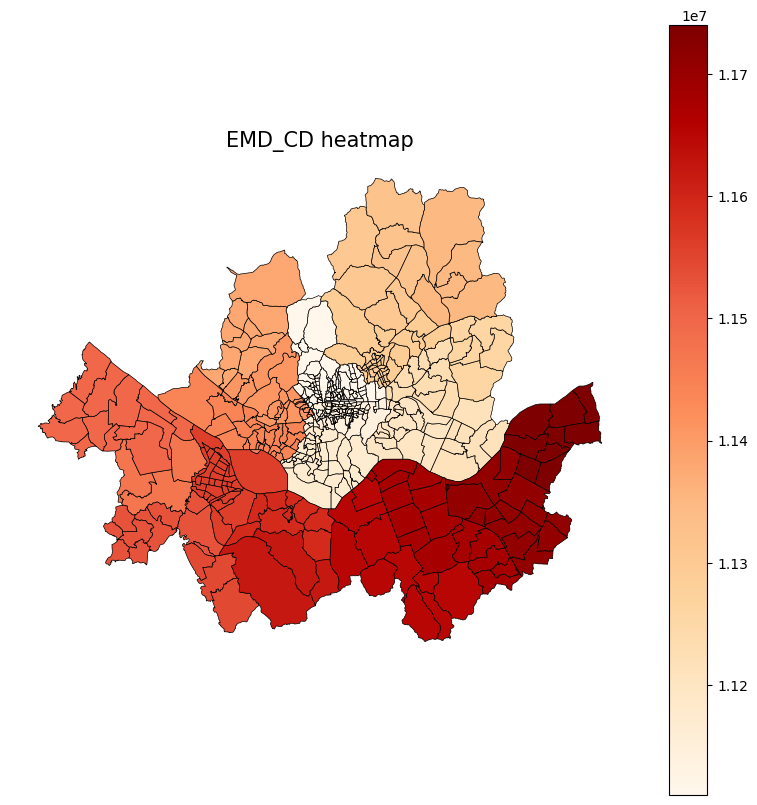

In [ ]:
import matplotlib.pyplot as plt

# 읍면동코드 숫자형으로 변환
gdf['EMD_CD'] = gdf['EMD_CD'].astype(int)

# 히트맵처럼 시각화
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(
    column='EMD_CD',       # 색상 기준 컬럼
    ax=ax,
    cmap='OrRd',              # 히트맵 스타일 컬러맵
    legend=True,
    edgecolor='black',
    linewidth=0.5
)

# 시각 설정
ax.set_title("EMD_CD heatmap", fontsize=15)
ax.axis('off')

plt.show()


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


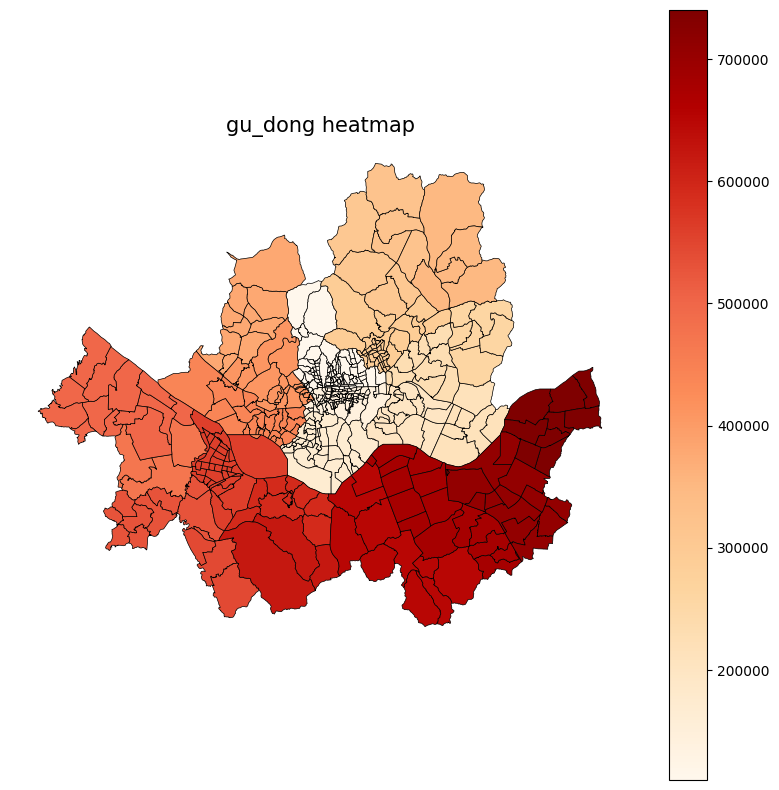

In [ ]:
# 읍면동코드 숫자형으로 변환
gdf['시군구동'] = gdf['시군구코드']+gdf['읍면동코드'].astype(str)
gdf['시군구동'] = gdf['시군구동'].astype(int)

# 히트맵처럼 시각화
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(
    column='시군구동',       # 색상 기준 컬럼
    ax=ax,
    cmap='OrRd',              # 히트맵 스타일 컬러맵
    legend=True,
    edgecolor='black',
    linewidth=0.5
)

# 시각 설정
ax.set_title("gu_dong heatmap", fontsize=15)
ax.axis('off')

plt.show()

![종로](https://mblogthumb-phinf.pstatic.net/MjAyMTA2MjVfNjMg/MDAxNjI0NjMxMTY2NzY2.m0-_83YGWrx2FmFVNF7RwUmQq4Wdpmx8VrhS-XR33o4g.f0n6Iv0qQbDT8bc8SH9GsnZmpSZGcCj1E8YVAifTysgg.JPEG.kodoc1/rs1800%EC%84%9C%EC%9A%B8_%EA%B0%81%EA%B5%AC_%EB%AA%A8%EC%96%91-%EB%8F%84%EC%8B%AC%EA%B6%8C-%ED%94%84%EB%9E%80%EC%AF%94%EC%97%AC%EC%A7%80%EB%8F%84008.JPG?type=w800)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


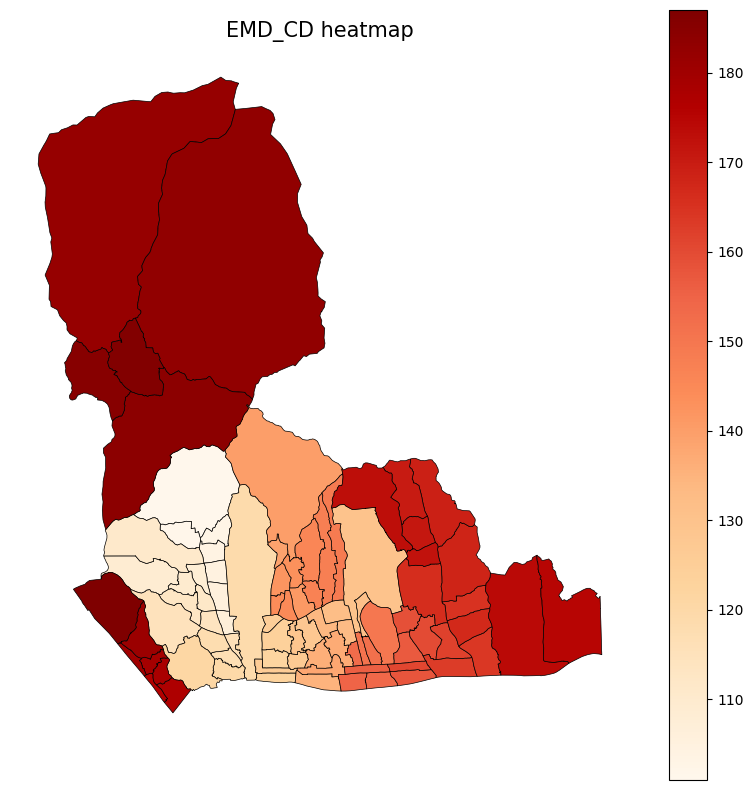

In [ ]:
import matplotlib.pyplot as plt

# 읍면동코드 숫자형으로 변환
gdf['EMD_CD'] = gdf['EMD_CD'].astype(int)
gdf00 = gdf[gdf['시군구코드']==gdf['시군구코드'].unique()[0]]
# 히트맵처럼 시각화
fig, ax = plt.subplots(figsize=(10, 10))
gdf00.plot(
    column='읍면동코드',       # 색상 기준 컬럼
    ax=ax,
    cmap='OrRd',              # 히트맵 스타일 컬러맵
    legend=True,
    edgecolor='black',
    linewidth=0.5
)

# 시각 설정
ax.set_title("EMD_CD heatmap", fontsize=15)
ax.axis('off')

plt.show()


# 인구분포관련 추가 컬럼생성

In [ ]:
counts = df.groupby(['법정동', '주택유형']).size().unstack(fill_value=0)

# 2. 필요한 컬럼 이름 변경 (예: 아파트 → 아파트_거래수)
counts.columns = [col + '_거래수' for col in counts.columns]

# 3. 원래 데이터프레임에 병합 (법정동 기준)
df = df.merge(counts, on='법정동', how='left')

In [ ]:
pop.head()

,0~4세_계,0~4세_한국인,0~4세_등록외국인,5~9세_계,5~9세_한국인,5~9세_등록외국인,10~14세_계,10~14세_한국인,10~14세_등록외국인,15~19세_계,...,90~94세_등록외국인,95~99세_계,95~99세_한국인,95~99세_등록외국인,100세 이상_계,100세 이상_한국인,100세 이상_등록외국인,합계_계,합계_한국인,합계_등록외국인
0,731.0,729.0,2.0,741.0,739.0,2.0,548.0,545.0,3.0,632.0,...,0.0,20.0,20.0,0.0,5.0,5.0,0.0,21329.0,21148.0,181.0
1,375.0,372.0,3.0,428.0,425.0,3.0,473.0,471.0,2.0,524.0,...,0.0,14.0,14.0,0.0,7.0,7.0,0.0,14032.0,13736.0,296.0
2,375.0,372.0,3.0,428.0,425.0,3.0,473.0,471.0,2.0,524.0,...,0.0,14.0,14.0,0.0,7.0,7.0,0.0,14032.0,13736.0,296.0
3,375.0,372.0,3.0,428.0,425.0,3.0,473.0,471.0,2.0,524.0,...,0.0,14.0,14.0,0.0,7.0,7.0,0.0,14032.0,13736.0,296.0
4,369.0,365.0,4.0,431.0,423.0,8.0,417.0,409.0,8.0,428.0,...,0.0,38.0,38.0,0.0,4.0,3.0,1.0,16167.0,15935.0,232.0


In [ ]:
pop.columns

Index(['0~4세_계', '0~4세_한국인', '0~4세_등록외국인', '5~9세_계', '5~9세_한국인', '5~9세_등록외국인',
       '10~14세_계', '10~14세_한국인', '10~14세_등록외국인', '15~19세_계', '15~19세_한국인',
       '15~19세_등록외국인', '20~24세_계', '20~24세_한국인', '20~24세_등록외국인', '25~29세_계',
       '25~29세_한국인', '25~29세_등록외국인', '30~34세_계', '30~34세_한국인', '30~34세_등록외국인',
       '35~39세_계', '35~39세_한국인', '35~39세_등록외국인', '40~44세_계', '40~44세_한국인',
       '40~44세_등록외국인', '45~49세_계', '45~49세_한국인', '45~49세_등록외국인', '50~54세_계',
       '50~54세_한국인', '50~54세_등록외국인', '55~59세_계', '55~59세_한국인', '55~59세_등록외국인',
       '60~64세_계', '60~64세_한국인', '60~64세_등록외국인', '65~69세_계', '65~69세_한국인',
       '65~69세_등록외국인', '70~74세_계', '70~74세_한국인', '70~74세_등록외국인', '75~79세_계',
       '75~79세_한국인', '75~79세_등록외국인', '80~84세_계', '80~84세_한국인', '80~84세_등록외국인',
       '85~89세_계', '85~89세_한국인', '85~89세_등록외국인', '90~94세_계', '90~94세_한국인',
       '90~94세_등록외국인', '95~99세_계', '95~99세_한국인', '95~99세_등록외국인', '100세 이상_계',
       '100세 이상_한국인', '100세 이상_등록외국인', '합계_계', '합계_한국인', '합계_등록외국인'],
     

In [ ]:
# 연령대별 합 계산
pop['0-19대인구'] = pop[['0~4세_계', '5~9세_계', '10~14세_계', '15~19세_계']].sum(axis=1)
pop['20-34대인구'] = pop[['20~24세_계', '25~29세_계', '30~34세_계']].sum(axis=1)
pop['35-64대인구'] = pop[['35~39세_계', '40~44세_계', '45~49세_계', '50~54세_계', '55~59세_계', '60~64세_계']].sum(axis=1)

# 비율 계산
pop['0-19대인구비'] = pop['0-19대인구'] / pop['합계_계']
pop['20-34대인구비'] = pop['20-34대인구'] / pop['합계_계']
pop['35-64대인구비'] = pop['35-64대인구'] / pop['합계_계']

# 필요 없으면 중간 컬럼 삭제
pop.drop(columns=['0-19대인구', '20-34대인구', '35-64대인구'], inplace=True)

In [ ]:
df[['0-19대인구비','20-34대인구비','35-64대인구비']] = pop[['0-19대인구비','20-34대인구비','35-64대인구비']]